In [ ]:
!pip install -q kaggle

In [ ]:
# Imports
import os
import glob
import shutil
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gspread as gs
import cv2
from ast import literal_eval
from PIL import Image
from google.colab import files
from google.colab import drive
from google.colab.patches import cv2_imshow
import time
import math

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# <b>Section 1. Importing Datasets</b>

In [ ]:
# Setting up Kaggle API
files.upload() # upload the kaggle.json in the data folder

{}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

In [ ]:
!kaggle datasets download -d pes12017000148/food-ingredients-and-recipe-dataset-with-images
!unzip '/content/food-ingredients-and-recipe-dataset-with-images.zip' -d '/content/gdrive/MyDrive/data/raw'

In [ ]:
import os
print(len(os.listdir('/content/gdrive/MyDrive/data/raw/Food Images/Food Images')))

13581


# <b> Section 2. Data Processing </b>

In [ ]:
list_img_names = os.listdir('/content/gdrive/MyDrive/data/raw/Food Images/Food Images')
labels = pd.read_csv('/content/gdrive/MyDrive/data/raw/labels.csv', index_col=0)

In [ ]:
# Check to see if all images in folder have a corresponding label
# Removes images from master list of images if no labels
no_labels = []
for i in list_img_names:
  print(i)
  if not (labels['Image_Name'].eq(i.replace(".jpg", ""))).any():
    print(f"ERROR: {i} not in labels.csv")
    no_labels.append(i)
else:
  print("done")

print(no_labels)
print(len(no_labels))
print(len(list_img_names))

for i in no_labels:
  list_img_names.remove(i)

Streaming output truncated to the last 5000 lines.
grilled-tomato-bell-pepper-gazpacho-239064.jpg
grilled-pounded-flank-steak-with-zucchini-salsa.jpg
fruit-juice-gummies-240066.jpg
grilled-zucchini-and-bell-pepper-fattoush-238777.jpg
fruit-smoothie-366400.jpg
granola-bark.jpg
gluten-free-cauliflower-pizza-with-mozzarella-kale-and-lemon.jpg
harissa-51185010.jpg
frozen-mint-chocolate-checkerboard-108191.jpg
gorgonzola-and-grape-pizza-235732.jpg
grapefruit-campari-granita-with-vanilla-whipped-cream-357517.jpg
grilled-apricots-with-almond-cream-and-fregolotta.jpg
goat-birria-tacos-with-cucumber-pico-de-gallo.jpg
ham-gruyere-and-tomato-toast-with-dijon-mustard-56389820.jpg
goat-cheese-stuffed-lamb-burgers-with-caramelized-red-onions.jpg
grilled-eggplant-stacks-with-tomato-and-feta-232478.jpg
grilled-lemongrass-lamb-chops-with-herbs-235748.jpg
green-salad-with-radishes-and-creamy-mustard-dressing-51262910.jpg
green-garlic-and-pea-soup-with-whipped-cream-51231720.jpg
grilled-mustard-broccoli.

### <b>Process data labels</b>

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn

def check_food(word, ingredients):
    syns = wn.synsets(str(word), pos = wn.NOUN)

    for syn in syns:
        if 'food' in syn.lexname() and word not in ingredients:
            return 1
    return 0

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
## DON'T NEED TO RUN THIS EVERY TIME
processed_labels = pd.DataFrame(columns=["Image_Name", "Ingredients"])

# Load ingredients for each image
for label, row in labels.iterrows():
  # Split the ingredients based on spaces
  raw_ingredients = row["Ingredients"]
  raw_ingredients = raw_ingredients.split()

  processed_ingredients = []
  for j in raw_ingredients:
    # Remove punctuation and numbers
    temp_ingredient = j.translate(str.maketrans('', '', string.punctuation))
    temp_ingredient = temp_ingredient.translate(str.maketrans('', '', string.digits))

    # Run each word through the WordNet synset. If word and noun save to list
    if check_food(temp_ingredient, processed_ingredients):
      processed_ingredients.append(temp_ingredient)

  # Save the image name and processed ingredients into new dataframe
  processed_dish = pd.DataFrame({
      "Image_Name": [row["Image_Name"]],
      "Ingredients": [processed_ingredients]
  })
  processed_labels = processed_labels.append(processed_dish)

# Save dataframe as .csv
processed_labels.to_csv("/content/gdrive/MyDrive/data/processed/processed_labels.csv")
print("done")

### <b>Process images and create dataloaders</b>

In [ ]:
# DON'T RUN CELL MULTIPLE TIMES, WANT TO ENSURE CONSISTENCY
# Takes like 1.5-2 hours to run once
# Split data into training, validation, and testing
# 70-15-15 split
# This is run before data augmentation

folders = ['training', 'validation', 'testing']

# Delete any previous data
for i in folders:
  for f in glob.glob(f'/content/gdrive/MyDrive/data/raw/{i}_images'):
    if f != f'/content/gdrive/MyDrive/data/raw/{i}_images':
      os.remove(f)

# Get list of all raw images, randomize, and split
unsplit_imgs = np.array(list_img_names)
np.random.shuffle(unsplit_imgs)

training_imgs = unsplit_imgs[0:int(len(unsplit_imgs)*0.7)]
valid_imgs = unsplit_imgs[int(len(unsplit_imgs)*0.7): int(len(unsplit_imgs)*0.7) + int(len(unsplit_imgs)*0.15)]
test_imgs = unsplit_imgs[int(len(unsplit_imgs)*0.7) + int(len(unsplit_imgs)*0.15): ]

# Save copy of each image in list into appropriate folder
folders_2 = [training_imgs, valid_imgs, test_imgs]
for i in range(len(folders_2)):
  for j in folders_2[i]:
    shutil.copyfile(f'/content/gdrive/MyDrive/data/raw/Food Images/Food Images/{j}',
                    f'/content/gdrive/MyDrive/data/raw/{folders[i]}_images/{j}')

print("done")

In [ ]:
# Workaround because I fucked up
for i in no_labels:
  if os.path.exists(f"/content/gdrive/MyDrive/data/raw/training_images/{i}"):
    os.remove(f"/content/gdrive/MyDrive/data/raw/training_images/{i}")
  elif os.path.exists(f"/content/gdrive/MyDrive/data/raw/validation_images/{i}"):
    os.remove(f"/content/gdrive/MyDrive/data/raw/validation_images/{i}")
  elif os.path.exists(f"/content/gdrive/MyDrive/data/raw/testing_images/{i}"):
    os.remove(f"/content/gdrive/MyDrive/data/raw/testing_images/{i}")

#### <b> Data Usage </b>
<i>Primary Model</i><br>
Use provided datasets to create required dataloaders in the training function. Unpack as a photo and label. Photo is a tensor of the photo and label is a list of the ingredients. Each index in the list of labels contains one word as a string (based on how the model is built, probably need to encode them with like one hot encoding or smth).
<br><br>

<i>Baseline Model</i><br>
All the initial images are in the raw/Food Images folder. The initial images were split into training, validation, and testing folders. You can load each image however you like, if you want augmentations, just use the composed "augmentation transform" above and labels can be found by taking the name of the file and running it through the labels_lookup dataframe.

###<b>Simplified Data </b>

In [ ]:
# load all ingredients
labels_lookup = pd.read_csv("/content/gdrive/MyDrive/data/processed/processed_labels.csv")
all_ingredients = []

for _, row in labels_lookup.iterrows():
  # Split the ingredients based on spaces
  label = row["Ingredients"] # Load row
  label = label.strip('][').replace("'", "").split(', ') # Turn into list
  label = list(map(str.lower,label)) # Lowercase everything
  all_ingredients.append(label)

print(len(all_ingredients))

13501


In [ ]:
# Turn plural ingredients into singular forms
import inflect
p = inflect.engine()

for i in range(len(all_ingredients)):

  for j in range(len(all_ingredients[i])-1, -1, -1):
    temp_ingred = all_ingredients[i][j]

    try:
      if p.singular_noun(temp_ingred) != False:
        if p.singular_noun(temp_ingred) in all_ingredients[i]:
          all_ingredients[i].pop(j)
        else:
          all_ingredients[i][j] = p.singular_noun(temp_ingred)
    except:
      print(temp_ingred)

In [ ]:
# Find most common ingredients
counter = Counter(all_ingredients[0])
for i in all_ingredients[1:]:
    counter.update(i)

counter.most_common()

[('cup', 11970),
 ('salt', 8866),
 ('oil', 7380),
 ('pepper', 5321),
 ('olive', 5066),
 ('kosher', 4924),
 ('sugar', 4836),
 ('garlic', 4177),
 ('juice', 3853),
 ('clove', 3830),
 ('cut', 3750),
 ('egg', 3444),
 ('lemon', 3272),
 ('onion', 3216),
 ('white', 3077),
 ('flour', 2859),
 ('piece', 2490),
 ('vegetable', 2433),
 ('cream', 2425),
 ('stick', 2385),
 ('water', 2351),
 ('vinegar', 2312),
 ('chicken', 1788),
 ('green', 1786),
 ('wine', 1742),
 ('vanilla', 1738),
 ('tomato', 1725),
 ('sauce', 1642),
 ('milk', 1625),
 ('parsley', 1599),
 ('cheese', 1581),
 ('slice', 1427),
 ('lime', 1417),
 ('serving', 1388),
 ('ginger', 1248),
 ('cilantro', 1172),
 ('chile', 1145),
 ('rice', 1134),
 ('orange', 1129),
 ('thyme', 1076),
 ('broth', 1065),
 ('shallot', 1036),
 ('cinnamon', 1028),
 ('bean', 1018),
 ('potato', 980),
 ('wedge', 941),
 ('bread', 924),
 ('honey', 921),
 ('mustard', 918),
 ('carrot', 871),
 ('garnish', 825),
 ('chocolate', 812),
 ('syrup', 806),
 ('scallion', 791),
 ('basil'

In [ ]:
# Get list of only recipes that have 3 or more of the ingredients
filter_ingred = ["salt", "oil", "pepper", "garlic", "lemon", "onion", "vinegar",
                 "egg", "chicken", "milk", "tomato", "rice", "potato",
                 "chocolate", "bread"]

filtered_dish = []
for _, row in labels_lookup.iterrows():
  if row["Image_Name"] != "#NAME?":
    label = row["Ingredients"] # Load row
    label = label.strip('][').replace("'", "").split(', ') # Turn into list
    label = list(map(str.lower,label)) # Lowercase everything

    temp_count = 0
    for j in filter_ingred:
      if j in label: temp_count += 1

    if temp_count >= 3:
      filtered_dish.append(row["Image_Name"]+".jpg")

for i in no_labels:
  if i in filtered_dish:
    filtered_dish.remove(i)

print(filtered_dish)
print(len(filtered_dish))

['miso-butter-roast-chicken-acorn-squash-panzanella.jpg', 'crispy-salt-and-pepper-potatoes-dan-kluger.jpg', 'thanksgiving-mac-and-cheese-erick-williams.jpg', 'italian-sausage-and-bread-stuffing-240559.jpg', 'instant-pot-lamb-haleem.jpg', 'spiced-lentil-and-caramelized-onion-baked-eggs.jpg', 'hot-pimento-cheese-dip-polina-chesnakova.jpg', 'caesar-salad-roast-chicken.jpg', 'chicken-and-rice-with-leeks-and-salsa-verde.jpg', 'gorditas-con-camarones.jpg', 'enfrijoladas.jpg', 'caramelized-plantain-parfait.jpg', 'chicken-and-potato-gratin-brown-butter-cream.jpg', 'roasted-beets-with-crispy-sunchokes-and-pickled-orange-ginger-puree.jpg', 'kale-and-pumpkin-falafels-with-pickled-carrot-slaw.jpg', 'maple-chile-roasted-pumpkin-with-quinoa-tabouli.jpg', 'sloppy-joe-shirred-eggs-with-spinach-vivian-howard.jpg', 'miso-squash-ramen-hetty-mckinnon.jpg', 'spicy-coconut-pumpkin-soup.jpg', 'baigan-chokha-trinidadian-broiled-grilled-mashed-eggplant.jpg', 'dads-trinidadian-curried-chicken.jpg', 'shrimp-creo

In [ ]:
## DON'T NEED TO RUN THIS EVERY TIME
processed_labels = pd.DataFrame(columns=["Image_Name", "Ingredients"])

# Load ingredients for each image
for item in filtered_dish:
  # Find ingredients based on image name in master lookup
  ingredients = labels_lookup.query(f"Image_Name=='{item[:-4]}'")["Ingredients"]
  ingredients = ingredients.tolist()[0].strip('][').replace("'", "").split(', ')

  # Filter ingredients
  processed_ingredients = []
  for i in ingredients:
    if i in filter_ingred:
      processed_ingredients.append(i)

  # Save the image name and processed ingredients into new dataframe
  processed_dish = pd.DataFrame({
      "Image_Name": [item],
      "Ingredients": [processed_ingredients]
  })
  processed_labels = processed_labels.append(processed_dish)

# Save dataframe as .csv
processed_labels.to_csv("/content/gdrive/MyDrive/data/processed/simplified_labelsv2.csv")
print("done")

In [ ]:
# DON'T RUN CELL MULTIPLE TIMES, WANT TO ENSURE CONSISTENCY
# Takes like 1.5-2 hours to run once
# Split data into training, validation, and testing
# 70-15-15 split
# This is run before data augmentation

folders = ['training', 'validation', 'testing']

# Delete any previous data
for i in folders:
  for f in glob.glob(f'/content/gdrive/MyDrive/data/raw/{i}_images'):
    if f != f'/content/gdrive/MyDrive/data/raw/{i}_images':
      os.remove(f)

# Get list of all raw images, randomize, and split
unsplit_imgs = np.array(filtered_dish)
np.random.shuffle(unsplit_imgs)

training_imgs = unsplit_imgs[0:int(len(unsplit_imgs)*0.7)]
valid_imgs = unsplit_imgs[int(len(unsplit_imgs)*0.7): int(len(unsplit_imgs)*0.7) + int(len(unsplit_imgs)*0.15)]
test_imgs = unsplit_imgs[int(len(unsplit_imgs)*0.7) + int(len(unsplit_imgs)*0.15): ]

# Save copy of each image in list into appropriate folder
folders_2 = [training_imgs, valid_imgs, test_imgs]
for i in range(len(folders_2)):
  for j in folders_2[i]:
    try: # cannot be bothered to fix it properly
      shutil.copyfile(f'/content/gdrive/MyDrive/data/raw/Food Images/Food Images/{j}',
                      f'/content/gdrive/MyDrive/data/raw/{folders[i]}_images/{j}')
    except:
      print("error")

print("done")

In [ ]:
folders = ['training', 'validation', 'testing']

for i in folders:
  print(f"{i}: {len(os.listdir(f'/content/gdrive/MyDrive/data/raw/{i}_images'))}")

training: 5749
validation: 1229
testing: 1232


In [ ]:
for j in folders:
  old_count = 0

  for i in os.listdir(f'/content/gdrive/MyDrive/data/raw/{j}_images'):
    if os.path.getmtime(f'/content/gdrive/MyDrive/data/raw/{j}_images/{i}') < 1680000000:
      old_count += 1

      os.remove(f'/content/gdrive/MyDrive/data/raw/{j}_images/{i}')

  print(old_count)

0
0
0


# <b>Section 3. Baseline Model</b>

In [ ]:
import numpy as np
import cv2 as cv
import pickle as pkl
import glob
import os
from joblib import Parallel, delayed
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###dont need to run this more than once its just to prepare the data files

In [ ]:
data_modes = ["training_images", "validation_images", "testing_images"]
image_data_path_base = "/content/drive/MyDrive/data/raw"
sift_data_path_base = "/content/drive/MyDrive/data/sift"
os.makedirs("/content/drive/MyDrive/data/sift/training_images")
os.makedirs("/content/drive/MyDrive/data/sift/testing_images")
os.makedirs("/content/drive/MyDrive/data/sift/validation_images")
sift = cv.SIFT_create()
for data_mode in data_modes:
  for img_path in glob.glob(os.path.join(image_data_path_base, data_mode, "*.jpg")):
    try:
      img = cv.imread(img_path)
      gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
      kp, des = sift.detectAndCompute(gray, None)
      with open(os.path.join(sift_data_path_base, data_mode, os.path.split(img_path)[1].split(".")[0]+".pkl"), "wb") as pkl_file:
        pkl.dump(des, pkl_file)
    except:
      print("Failed", img_path)

In [ ]:
from ast import literal_eval
import pandas as pd
processedlabelsdf = pd.read_csv("/content/drive/MyDrive/data/processed/simplified_labelsv2.csv")
labels_set = set()
processedlabelsdf["Ingredients"] = processedlabelsdf["Ingredients"].apply(literal_eval)
for ingredients in processedlabelsdf["Ingredients"]:
  for ingredient in ingredients:
    labels_set.add(ingredient.lower())

print(labels_set)

{'potato', 'salt', 'onion', 'garlic', 'vinegar', 'tomato', 'pepper', 'chocolate', 'egg', 'milk', 'bread', 'chicken', 'rice', 'oil', 'lemon'}


In [ ]:
processedlabelsdf.drop("Unnamed: 0", axis=1, inplace=True)
processedlabelsdf.head()

Image_Name  \
0  miso-butter-roast-chicken-acorn-squash-panzane...   
1     crispy-salt-and-pepper-potatoes-dan-kluger.jpg   
2     thanksgiving-mac-and-cheese-erick-williams.jpg   
3      italian-sausage-and-bread-stuffing-240559.jpg   
4                        instant-pot-lamb-haleem.jpg   

                                         Ingredients  
0  [chicken, salt, pepper, bread, oil, onion, vin...  
1                                [egg, salt, pepper]  
2                [milk, garlic, onion, pepper, salt]  
3                             [oil, garlic, chicken]  
4           [rice, salt, oil, garlic, pepper, onion]

In [ ]:
not_missing_files = []
sift_base_path = "/content/drive/MyDrive/data/sift"
data_modes = ["training_images", "validation_images", "testing_images"]
for data_mode in data_modes:
  not_missing_files.extend([os.path.split(name)[1].split(".")[0] for name in glob.glob(os.path.join(sift_base_path, data_mode, "*.pkl"))])
print(not_missing_files)

['dried-cherry-and-ginger-cannoli-231310', 'zucchini-bacon-fritters-with-basil-mayo-dipping-sauce-357981', 'italian-sausage-meatball-heroes-238290', 'romesco-pasta-salad-with-basil-and-parmesan', 'baked-egg-custard-with-gruyere-and-chives-350969', 'devils-food-cake-with-chocolate-spiderweb-356170', 'lime-in-the-coconut-macaroons-51147500', 'strawberry-lemonade-smash-51155530', 'grilled-soy-tamarind-denver-steaks-51238320', 'creamy-wild-salmon-with-kale', 'salmon-with-peas-pea-tendrils-and-dill-cucumber-sauce-231874', 'cooked-semi-polished-rice-haiga-mai', 'cheddar-rice-fritters-238076', 'pork-chops-and-padron-chiles-en-escabeche', 'oxtail-bourguinonne-363718', 'roasted-potatoes-and-shallots-350605', 'arinato-cocktail-ivy-mix', 'lavender-and-peach-bellini-242384', 'fish-taco-platter-233703', 'linguine-avgolemono-with-artichoke-hearts-and-green-beans-234147', 'baked-eggs-with-coconut-milk-and-cilantro', 'shrimp-with-sherry-tomato-sauce-236405', 'roasted-beets-with-crispy-sunchokes-and-pi

In [ ]:
train_only = []
for sift_train_data in glob.glob(os.path.join(sift_base_path, "training_images", "*.pkl")):
  if os.path.split(sift_train_data)[1].split(".")[0] in not_missing_files:
    train_only.append(os.path.split(sift_train_data)[1].split(".")[0])

In [ ]:
X_train = []
train_useful = []
for pickle_file in tqdm(sorted(glob.glob(os.path.join(sift_base_path, "training_images", "*.pkl")))):
  if os.path.split(pickle_file)[1].split(".")[0] in train_only:
    with open(pickle_file, "rb") as pickle_buffer:
      res = pkl.load(pickle_buffer)
      if res is not None and res.shape[0] < 500:
        X_train.append(res)
        train_useful.append(os.path.split(pickle_file)[1].split(".")[0])

100%|██████████| 9428/9428 [00:15<00:00, 610.94it/s]


In [ ]:
raw_xtrain = X_train

In [ ]:
len(X_train)

7095

In [ ]:
y_train = []
labels = sorted(list(labels_set))
i = 0
for index, row in processedlabelsdf.iterrows():
  if row["Image_Name"].split(".")[0] in train_useful:
    curr_labels = row["Ingredients"]
    match_array = np.isin(np.array(labels), np.array(curr_labels)).astype(int)
    y_train.append((row["Image_Name"], match_array))
    i += 1

In [ ]:
y_train = sorted(y_train, key=lambda x: x[0])
y_train = [b for a, b in y_train]
y_train = np.array(y_train)

In [ ]:
X_train = raw_xtrain[:1000]
for a in range(len(X_train)):
  x = X_train[a].flatten()
  x = np.pad(x, (0, 128*500-x.shape[0]), "constant", constant_values=(0,0))
  X_train[a] = x
# X_train = [np.pad(a.flatten(), (128*(500-a.shape[0]),), "constant", constant_values=0) for a in X_train]
X_train = np.vstack(X_train)

In [ ]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.24.1

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 67.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.1 which is incompatible.
imbalanced-learn 0.10.1 requires scikit-learn>=1.0.2, but you have scikit-learn 0.24.1 which is incompatible.


In [ ]:
!pip uninstall scikit-multilearn -y
!pip install scikit-multilearn==0.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 9.1 MB/s eta 0:00:00


In [ ]:
from skmultilearn.adapt import MLkNN
classifier = MLkNN(k=3)

In [ ]:
# x = X_train[:3000]
y = y_train[:1000]

In [ ]:
classifier.fit(X_train, y.astype(int))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


MLkNN(k=3)

In [ ]:
with open("/content/drive/MyDrive/baselinemodel.pkl", "wb") as file:
  pkl.dump(classifier, file)

In [ ]:
with open("/content/drive/MyDrive/baselinemodel.pkl", "rb") as file:
  classifier = pkl.load(file)

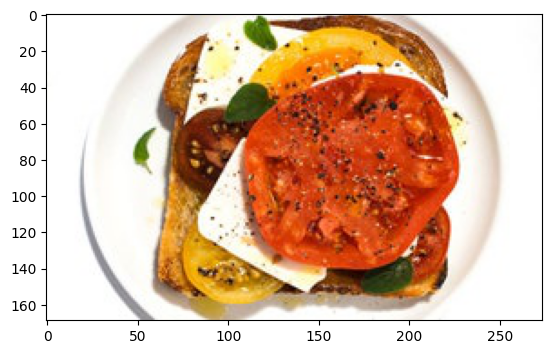

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

img = cv.imread("/content/drive/MyDrive/data/raw/testing_images/tomato-feta-open-face-sandwich-51108060.jpg")
sift = cv.SIFT_create()
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
kp, des = sift.detectAndCompute(gray, None)
des = np.vstack(des)
des = des.astype(np.float32)
des = des.reshape(1, -1)

# for i in range(len(predictions)):
#   if predictions[i] == 1:
#     print(labels[i])
des = np.pad(des.flatten(), (0, 128*500-des.shape[1]), "constant", constant_values=(0,0))
des = des.reshape(1, -1)
image = mpimg.imread("/content/drive/MyDrive/data/raw/testing_images/tomato-feta-open-face-sandwich-51108060.jpg")
plt.imshow(image)

In [ ]:
predictions = classifier.predict(des)

In [ ]:
labels = sorted(list(labels_set))
for a in predictions.rows:
  for e in a:
    print(labels[e])

bread
chicken
egg


In [ ]:
sift_base_path = "/content/drive/MyDrive/data/sift"
test_only = []
for sift_test_data in glob.glob(os.path.join(sift_base_path, "testing_images", "*.pkl")):
  if os.path.split(sift_test_data)[1].split(".")[0] in not_missing_files:
    test_only.append(os.path.split(sift_test_data)[1].split(".")[0])
X_test = []
test_useful = []
for pickle_file in tqdm(sorted(glob.glob(os.path.join(sift_base_path, "testing_images", "*.pkl")))):
  if os.path.split(pickle_file)[1].split(".")[0] in test_only:
    with open(pickle_file, "rb") as pickle_buffer:
      res = pkl.load(pickle_buffer)
      if res is not None and res.shape[0] < 500:
        X_test.append(res)
        test_useful.append(os.path.split(pickle_file)[1].split(".")[0])

y_test = []
labels = sorted(list(labels_set))
for index, row in processedlabelsdf.iterrows():
  if row["Image_Name"].split(".")[0] in test_useful:
    curr_labels = row["Ingredients"]
    match_array = np.isin(np.array(labels), np.array(curr_labels)).astype(int)
    y_test.append((row["Image_Name"], match_array))

y_test = sorted(y_test, key=lambda x: x[0])
y_test = [b for a, b in y_test]
y_test = np.array(y_test)

100%|██████████| 2022/2022 [01:00<00:00, 33.42it/s] 


In [ ]:
raw_xtest = X_test

In [ ]:
X_test = raw_xtest[:500]
for a in range(len(X_test)):
  x = X_test[a].flatten()
  x = np.pad(x, (0, 128*500-x.shape[0]), "constant", constant_values=(0,0))
  X_test[a] = x
# X_train = [np.pad(a.flatten(), (128*(500-a.shape[0]),), "constant", constant_values=0) for a in X_train]
X_test = np.vstack(X_test)

In [ ]:
test_preds = classifier.predict(X_test)

In [ ]:
y_test = y_test[:500]

In [ ]:
X_test[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
for a in test_preds[0].rows:
  for e in a:
    print(labels[e])

bread
egg
milk


In [ ]:
y_test.shape

(500, 15)

In [ ]:
test_preds.shape

(500, 7)

In [ ]:
def get_accuracy(predicted, actual):
  predict = predicted.flatten()
  count = 0
  label = actual.flatten()
  for i in range(len(predict)):
    if predict[i] > 0.5:
      predict[i] = 1
    else:
      predict[i] = 0
  for i in range(len(predict)):
        if predict[i] == label[i]:
            count += 1
  return float(count/len(predict))

In [ ]:
get_accuracy(test_preds.toarray(), y_test)

0.5451428571428572

# <b>Section 4. Deep Neural Net</b>

# Training Set up

In [ ]:
### from previous section, generating a label/ingredient look up table
data_dir = "/content/gdrive/MyDrive/data/raw/training_images"
processedlabelsdf = pd.read_csv("/content/gdrive/MyDrive/data/processed/simplified_labelsv2.csv")
labels_set = set()
processedlabelsdf["Ingredients"] = processedlabelsdf["Ingredients"].apply(literal_eval)
for ingredients in processedlabelsdf["Ingredients"]:
  for ingredient in ingredients:
    labels_set.add(ingredient.lower())
print(labels_set)
print(processedlabelsdf)

{'pepper', 'milk', 'chocolate', 'egg', 'garlic', 'chicken', 'vinegar', 'rice', 'potato', 'oil', 'onion', 'salt', 'lemon', 'bread', 'tomato'}
      Unnamed: 0                                         Image_Name  \
0              0  miso-butter-roast-chicken-acorn-squash-panzane...   
1              0     crispy-salt-and-pepper-potatoes-dan-kluger.jpg   
2              0     thanksgiving-mac-and-cheese-erick-williams.jpg   
3              0      italian-sausage-and-bread-stuffing-240559.jpg   
4              0                        instant-pot-lamb-haleem.jpg   
...          ...                                                ...   
8201           0       tomato-garlic-and-potato-frittata-105017.jpg   
8202           0  cornmeal-pancakes-with-honey-pecan-butter-1085...   
8203           0  dandelion-salad-with-warm-bacon-dressing-10637...   
8204           0  israeli-couscous-with-roasted-butternut-squash...   
8205           0  mexican-poblano-spinach-and-black-bean-lasagne...   

      

In [ ]:
def label_encoding(word, lookup):
  np_lookup = np.array(list(lookup))
  label = torch.zeros([1,len(np_lookup)], dtype=torch.int32)

  for i in range(len(np_lookup)):
    if np_lookup[i] in word:
      label[0, i] = 1
    else:
      label[0, i] = 0
  return label

In [ ]:
default_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((160,160)),
    transforms.ToTensor()
])

augmentation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((160,160)),
    transforms.ColorJitter((0.8, 1.2),
                           (0.8, 1.2),
                           (0.8, 1.2)),
    transforms.RandomRotation((0, 360)),
    transforms.ToTensor()
])
class MultilabelDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

def dataset_load(directory, num_of_sample, default_transform, augmentation_transform, augment=False):
  x = []
  y = []
  counter = 0
  for root, dirs, files in os.walk(directory):
    for filename in files[:num_of_sample]:
      photo = cv2.imread(os.path.join(root, filename))
      if(type(photo) != np.ndarray):
        continue
      if len(photo.shape) == 1:
        photo = cv2.cvtColor(photo, cv2.COLOR_GRAY2RGB)
      else:
        photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)
      if augment:
        photo = augmentation_transform(photo)
      else:
        photo = default_transform(photo)

      try:
        row_num = processedlabelsdf[processedlabelsdf["Image_Name"] == filename].index
        y.append(label_encoding(processedlabelsdf["Ingredients"][row_num[0]], labels_set).squeeze())
        x.append(photo)
      except IndexError:
        continue
      counter += 1


  return x, y

In [ ]:
X_train_def, Y_train_def = dataset_load('/content/gdrive/MyDrive/data/raw/training_images/', len(os.listdir('/content/gdrive/MyDrive/data/raw/training_images')),
                                default_transform = default_transform,
                                augmentation_transform = default_transform, augment=False)
X_train_aug, Y_train_aug = dataset_load('/content/gdrive/MyDrive/data/raw/training_images/', int(len(os.listdir('/content/gdrive/MyDrive/data/raw/training_images'))/2),
                                default_transform = default_transform,
                                augmentation_transform = default_transform, augment=True)
X_train = X_train_def + X_train_aug
Y_train = Y_train_def + Y_train_aug
X_valid, Y_valid = dataset_load('/content/gdrive/MyDrive/data/raw/validation_images/', len(os.listdir('/content/gdrive/MyDrive/data/raw/validation_images')),
                                default_transform = default_transform,
                                augmentation_transform = default_transform, augment=False)
Y_train = [i.type(torch.float) for i in Y_train]
Y_valid = [i.type(torch.float) for i in Y_valid]

train_set = MultilabelDataset(X_train, Y_train)
valid_set = MultilabelDataset(X_valid, Y_valid)

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def get_accuracy(predicted, actual):
  predict = predicted.flatten()
  count = 0
  label = actual.flatten()
  for i in range(len(predict)):
    if predict[i] > 0.5:
      predict[i] = 1
    else:
      predict[i] = 0
  for i in range(len(predict)):
        if predict[i] == label[i]:
            count += 1
  return float(count/len(predict))

def evaluate(net, val_loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    correct = 0
    total_loss = 0.0
    total_err = 0.0
    total_images = 0
    total_acc = 0.0
    for imgs, labels in iter(val_loader):
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        outputs = net(imgs)
        loss = criterion(outputs, labels)
        total_images += imgs.shape[0]
        total_err += 1 - get_accuracy(outputs, labels)
        total_loss += loss.item()
        total_acc += get_accuracy(outputs, labels)
    acc = float(total_acc)/len(val_loader)
    err = float(total_err) / len(val_loader)
    loss = float(total_loss) / len(val_loader)
    return err, loss, acc

In [ ]:
def train(net, train_data, val_data, batch_size = 256, learning_rate = 0.001, num_epochs = 1, plot = False):
  # set random seed
  torch.manual_seed(3)
  # defining criterion model

  train_loader = DataLoader(dataset= train_data, shuffle=False, batch_size=batch_size)
  val_loader = DataLoader(dataset= val_data, shuffle=False, batch_size=batch_size)
  criterion = nn.BCELoss()
  optimizer = optim.NAdam(net.parameters(), lr = learning_rate)
  #creating zero vectors to store checkpoint values
  train_err = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  train_acc = np.zeros(num_epochs)

  val_err = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)
  val_acc = np.zeros(num_epochs)
  start_time = time.time()
  total_epoch = 0
  for epoch in range(num_epochs):
    correct = 0
    total_train_loss = 0.0
    total_train_err = 0.0
    total_images = 0
    total_accuracy = 0.0
    for imgs, labels in iter(train_loader):
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        # Forward pass, backward pass, and optimize
        outputs = net(imgs)

        # computing loss
        loss = criterion(outputs, labels)
        # backward pass
        loss.backward()
        # making update
        optimizer.step()
        # empty gradient
        optimizer.zero_grad()

        total_train_loss += loss.item()
        total_accuracy += get_accuracy(outputs, labels)
        total_train_err += 1 - get_accuracy(outputs, labels)
        total_images += imgs.shape[0]
        total_epoch += len(labels)
    train_err[epoch] = float(total_train_err) / len(train_loader)
    train_loss[epoch] = float(total_train_loss) /len(train_loader)
    train_acc[epoch] = float(total_accuracy) / len(train_loader)
    val_err[epoch], val_loss[epoch], val_acc[epoch] = evaluate(net, val_loader, criterion)

    print(("Epoch {}:  Train loss: {},  Train acc: {}|"+
            " Validation loss: {}, Validation acc: {}").format(
                epoch + 1,
                train_loss[epoch],
                train_acc[epoch],
                val_loss[epoch], val_acc[epoch]))
        # Save the current model (checkpoint) to a file
    model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
    torch.save(net.state_dict(), model_path)
  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time

  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
  epochs = np.arange(1, num_epochs + 1)
  np.savetxt("{}_train_err.csv".format(model_path), train_err)
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_err.csv".format(model_path), val_err)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
  if plot == True:
    plot_training_curve(model_path)

# Current Model

In [ ]:
# similar to VGG architecture: https://blog.paperspace.com/vgg-from-scratch-pytorch/, but scaled down

class CNNV4(nn.Module):
    def __init__(self, num_classes):
        super(CNNV4, self).__init__()
        self.name = "APS360_CNNV4"
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            # 3, 160, 160 to 64, 160, 160
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            # 64, 160, 160 to 64, 160, 160
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 64, 160, 160 to 64, 80, 80
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            # 64, 80, 80 to 128, 80, 80
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            # 128, 80, 80 to 128, 80, 80
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 128, 80, 80 to 128, 40, 40
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        # self.layer5 = nn.Sequential(
        #     nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        #     # 128, 40, 40 to 256, 40, 40
        #     nn.BatchNorm2d(256),
        #     nn.ReLU())

        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(40*40*128, 25),
            nn.ReLU())

        # self.fc1 = nn.Sequential(
        #     nn.Dropout(0.3),
        #     nn.Linear(25, 25),
        #     nn.ReLU())

        self.fc2 = nn.Sequential(
            nn.Linear(25, len(np.array(list(labels_set)))),
            nn.Sigmoid())


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        # out = self.fc1(out)
        out = self.fc2(out)
        return out

CUDA is available!  Training on GPU ...
Epoch 1:  Train loss: 11.341693164671169,  Train acc: 0.6440487132352942| Validation loss: 2.804085206985474, Validation acc: 0.6919352532679739
Epoch 2:  Train loss: 0.9155224561691284,  Train acc: 0.749322916666667| Validation loss: 0.5449941277503967, Validation acc: 0.7868249591503268
Epoch 3:  Train loss: 0.520952565705075,  Train acc: 0.7891069240196078| Validation loss: 0.5043519496917724, Validation acc: 0.7896149918300653
Epoch 4:  Train loss: 0.4980589896440506,  Train acc: 0.7914384191176471| Validation loss: 0.49081871509552, Validation acc: 0.7955688316993464
Epoch 5:  Train loss: 0.49100707909640146,  Train acc: 0.7958379289215685| Validation loss: 0.4899643242359161, Validation acc: 0.795594362745098
Epoch 6:  Train loss: 0.4912777700844933,  Train acc: 0.7963848039215687| Validation loss: 0.4981474995613098, Validation acc: 0.7948897058823529
Epoch 7:  Train loss: 0.4850533508202609,  Train acc: 0.7967233455882354| Validation loss

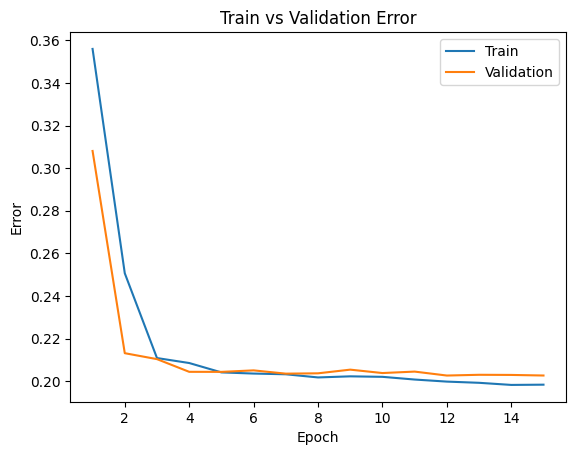

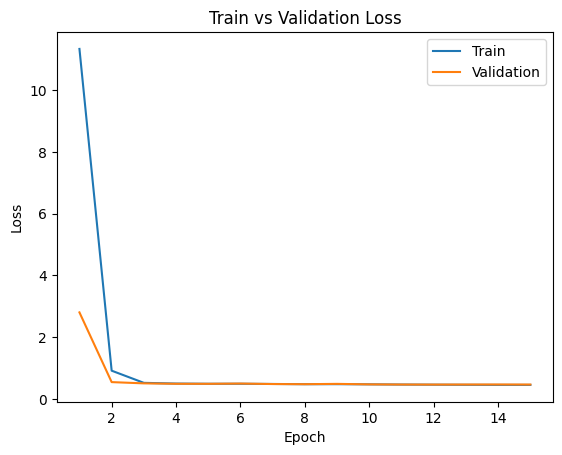

In [ ]:
use_cuda = True
CNNV4_003_256_15 = CNNV4(15)
if use_cuda and torch.cuda.is_available():
  CNNV4_003_256_15.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(CNNV4_003_256_15, train_set, valid_set, learning_rate = 0.003, batch_size = 256, num_epochs= 15, plot = True)

CUDA is available!  Training on GPU ...
Epoch 1:  Train loss: 10.078831073115854,  Train acc: 0.7425704656862745| Validation loss: 6.1110350608825685, Validation acc: 0.786734068627451
Epoch 2:  Train loss: 3.7575347598861244,  Train acc: 0.7684512867647059| Validation loss: 2.858263635635376, Validation acc: 0.7605953839869282
Epoch 3:  Train loss: 2.121291970505434,  Train acc: 0.7765425857843139| Validation loss: 1.8010364532470704, Validation acc: 0.7601470588235295
Epoch 4:  Train loss: 1.4444753194556517,  Train acc: 0.7853538602941177| Validation loss: 1.6746567964553833, Validation acc: 0.7820588235294117
Epoch 5:  Train loss: 0.9043771738515181,  Train acc: 0.7840456495098039| Validation loss: 0.49459097981452943, Validation acc: 0.7857526552287581
Epoch 6:  Train loss: 0.47134556489832263,  Train acc: 0.7939966299019606| Validation loss: 0.46882961988449096, Validation acc: 0.7910171568627451
Epoch 7:  Train loss: 0.45881665015921874,  Train acc: 0.7992984068627453| Validatio

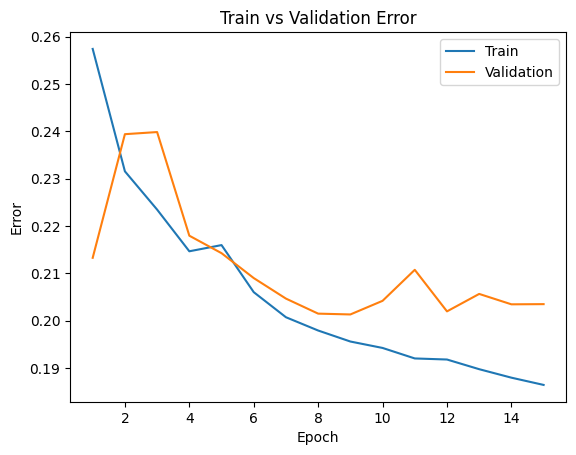

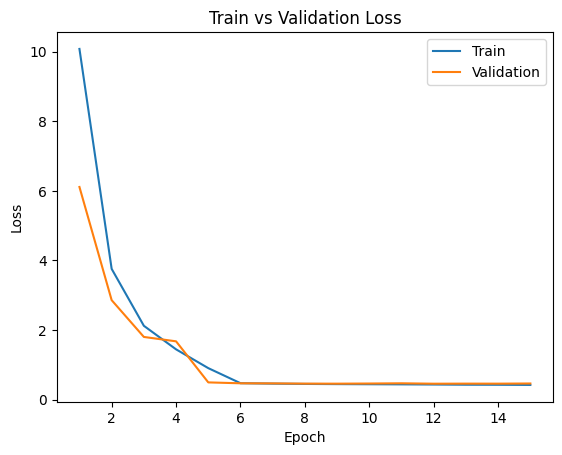

In [ ]:
# I USED THIS ONE AS THE FINAL MODEL
use_cuda = True
CNNV4_003_256_15 = CNNV4(15)
if use_cuda and torch.cuda.is_available():
  CNNV4_003_256_15.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(CNNV4_003_256_15, train_set, valid_set, learning_rate = 0.003, batch_size = 256, num_epochs= 15, plot = True)

In [ ]:
best = CNNV4(15)
model_path = get_model_name("APS360_CNNV4", 256, 0.003, 14)
state = torch.load(model_path)
best.load_state_dict(state)
torch.save(best.state_dict(), 'APS360_CNNV4_256_0.003_14_0406.pth')

# download checkpoint file

# Testing

In [ ]:
x_test, y_test = dataset_load('/content/gdrive/MyDrive/data/raw/testing_images/', len(os.listdir('/content/gdrive/MyDrive/data/raw/testing_images')),
                                default_transform = default_transform,
                                augmentation_transform = default_transform, augment=False)

In [ ]:
state = torch.load('/content/gdrive/MyDrive/data/APS360_CNNV4_256_0.003_14_0406-2.pth')
best.load_state_dict(state)

<All keys matched successfully>

In [ ]:
test_dataloader = DataLoader(dataset=MultilabelDataset(x_test, y_test), shuffle=False)
print(len(test_dataloader))
outputs = []
labels = []
counter = 0
for imgs, label in iter(test_dataloader):
  output= best(imgs).squeeze().detach().numpy()
  labels.append(label.squeeze().detach().numpy())
  for i in range(len(output)):
    if output[i] > 0.5:
      output[i] = 1
    else:
      output[i] = 0
  outputs.append(output)

print(get_accuracy(np.array(outputs), np.array(labels)))

1232
0.7843073593073593


In [ ]:
def one_hot_to_label(one_hot, label, label_set):
  prediction = []
  actual = []
  for i in range(len(one_hot)):
    if one_hot[i] == 1:
      prediction.append(label_set[i])
    if label[i] == 1:
      actual.append(label_set[i])

  return prediction, actual

In [ ]:
print(list(labels_set))

['chocolate', 'oil', 'tomato', 'garlic', 'lemon', 'chicken', 'salt', 'pepper', 'egg', 'milk', 'bread', 'potato', 'vinegar', 'onion', 'rice']


In [ ]:
output_array = np.array(outputs)
label_array = np.array(labels)
prediction_text = []
actual_text = []
for i in range(1232):
  prediction, actual = one_hot_to_label(output_array[i], label_array[i], list(labels_set))
  prediction_text.append(prediction)
  actual_text.append(actual)
df = pd.DataFrame(prediction_text)
with open('prediction.txt', 'w') as csv_file:
    df.to_csv(path_or_buf=csv_file)
df = pd.DataFrame(actual_text)
with open('actual.text', 'w') as csv_file:
    df.to_csv(path_or_buf=csv_file)
# workaround because i didn't do the dataloader right (forgot the image name), saved the prediction and actual texting.txt
for root, dirs, files in os.walk("/content/gdrive/MyDrive/data/raw/testing_images"):
    for filename in files[:1232]:
      print(filename)

In [ ]:
photo_predict = {}
actual = open("/content/gdrive/MyDrive/data/testing/actual_text.txt")
actual_line_array = []
actual_lines = actual.readlines()
for i in actual_lines:
    actual_line_array.append(i.split(" ")[1:-1])
actual.close()

predict = open("/content/gdrive/MyDrive/data/testing/prediction_text.txt")
predict_line_array = []
predict_lines = predict.readlines()
for i in predict_lines:
    predict_line_array.append(i.split(" ")[1:-1])
predict.close()

run_order = open("/content/gdrive/MyDrive/data/testing/run_order.txt")
run_order_lines = run_order.readlines()
for i in range(len(run_order_lines)):
    photo_predict[run_order_lines[i].split("\n")[0]] = {"actual": actual_line_array[i], "prediction": predict_line_array[i]}

{'kale-minestrone-with-pistou-51264070.jpg': {'actual': ['oil', 'tomato', 'garlic', 'lemon', 'salt', 'pepper', 'onion'], 'prediction': ['oil', 'salt', 'pepper']}, 'berry-spinach-salad-with-toasted-hazelnuts.jpg': {'actual': ['oil', 'lemon', 'salt', 'pepper'], 'prediction': ['oil', 'garlic', 'salt', 'pepper']}, 'roasted-mixed-peppers-with-capers-and-marjoram-359372.jpg': {'actual': ['oil', 'garlic', 'vinegar'], 'prediction': ['oil', 'garlic', 'salt', 'pepper']}, 'short-ribs-slow-roasted-in-coconut-milk.jpg': {'actual': ['garlic', 'salt', 'milk', 'rice'], 'prediction': ['oil', 'salt', 'pepper', 'rice']}, 'buttery-pull-apart-dinner-rolls.jpg': {'actual': ['oil', 'garlic', 'salt', 'milk', 'bread'], 'prediction': ['oil', 'salt', 'pepper']}, 'vanilla-maple-french-toast-with-warm-berry-preserves-231281.jpg': {'actual': ['salt', 'milk', 'bread'], 'prediction': ['oil', 'salt', 'pepper']}, 'meat-loaf-with-mushroom-gravy.jpg': {'actual': ['oil', 'tomato', 'pepper', 'bread', 'onion'], 'prediction'

In [ ]:
def precision_recall_f1(label, predict_line_array, actual_line_array):
    TP = 0
    FP = 0
    FN = 0
    for i in range(len(run_order_lines)):
        if label in predict_line_array[i] and label in actual_line_array[i]:
            TP += 1;
        elif label not in predict_line_array[i] and label in actual_line_array[i]:
            FN += 1;
        elif label in predict_line_array[i] and label not in actual_line_array[i]:
            FP += 1
    if(TP == 0 and (TP+FP) == 0):
        return [1, TP/(TP+FN), 2*TP/(2*TP+FP+FN)]
    return [TP/(TP+FP), TP/(TP+FN), 2*TP/(2*TP+FP+FN)]

In [ ]:
quantitative = {}
counter = {'chocolate': 812, "oil": 7380, "tomato": 1725, "garlic": 4177, "lemon": 3272, "chicken": 1788, "salt": 8866, "pepper": 5321, "egg": 3444, "milk": 1625, "bread": 924, "potato": 980, "vinegar": 2312, "onion": 3216, "rice": 1134}
for i in list(labels_set):
  p = precision_recall_f1(i, predict_line_array, actual_line_array)
  p.append(int(counter[i]))
  quantitative[i] = p
df = pd.DataFrame(data=quantitative, index=["Precision", "Recall", "F1", "Number of Appearances"])
df

pepper    milk  chocolate          egg  \
Precision                 0.575198     1.0        1.0     0.190476   
Recall                    0.922426     0.0        0.0     0.021739   
F1                        0.708559     0.0        0.0     0.039024   
Number of Appearances  5321.000000  1625.0      812.0  3444.000000   

                            garlic  chicken      vinegar         rice  potato  \
Precision                 0.534435      1.0     0.166667     0.096429     1.0   
Recall                    0.344583      0.0     0.003247     0.178808     0.0   
F1                        0.419006      0.0     0.006369     0.125290     0.0   
Number of Appearances  4177.000000   1788.0  2312.000000  1134.000000   980.0   

                               oil        onion         salt        lemon  \
Precision                 0.764754     0.285714     0.778169     0.267241   
Recall                    0.990446     0.006711     0.923720     0.092814   
F1                        0.863090     0.013115     0.844720     0.137778   
Number of Appearances  7380.000000  3216.000000  8866.000000  3272.000000   

                       bread  tomato  
Precision                0.0     1.0  
Recall                   0.0     0.0  
F1                       0.0     0.0  
Number of Appearances  924.0  1725.0

grilled-salmon-collars.jpg
{'actual': ['oil', 'garlic', 'salt', 'rice'], 'prediction': ['oil', 'garlic', 'salt', 'pepper', 'rice']}


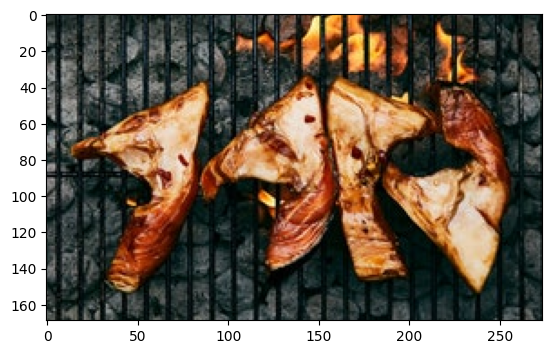

In [ ]:
def showresult(name):
  photo = cv2.imread("/content/gdrive/MyDrive/data/raw/testing_images/" + name)
  RGB_img = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)
  plt.imshow(RGB_img)
  print(name)
  print(photo_predict[name])

#Illustration of Sample Output
names = ["grilled-salmon-collars.jpg", "pasta-with-sun-gold-tomatoes-365185.jpg", "als-bloody-best-234122.jpg", "brioche-363478.jpg", "cold-soba-noodles-51262810.jpg", "chocolate-dipped-salted-caramel-marshmallows-51151820.jpg", "pasta-with-brown-butter-whole-lemon-and-parmesan.jpg"]
showresult(names[0])

pasta-with-sun-gold-tomatoes-365185.jpg
{'actual': ['oil', 'garlic', 'salt', 'pepper'], 'prediction': ['oil', 'garlic', 'salt', 'pepper', 'rice']}


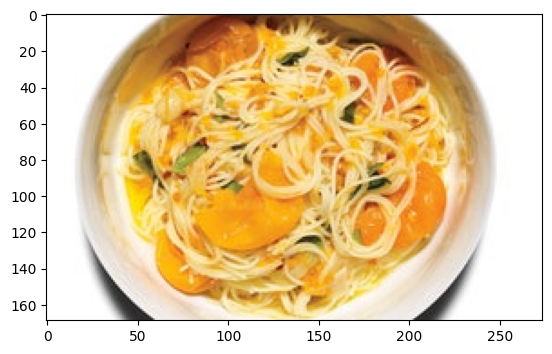

In [ ]:
showresult(names[1])

als-bloody-best-234122.jpg
{'actual': ['tomato', 'lemon', 'salt', 'pepper'], 'prediction': ['oil', 'salt', 'pepper']}


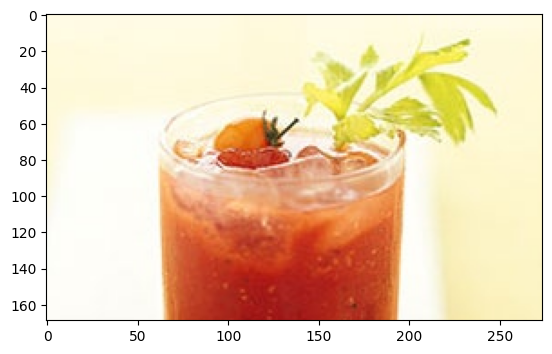

In [ ]:
showresult(names[2])

brioche-363478.jpg
{'actual': ['salt', 'egg', 'milk', 'bread'], 'prediction': ['oil', 'garlic', 'salt', 'pepper']}


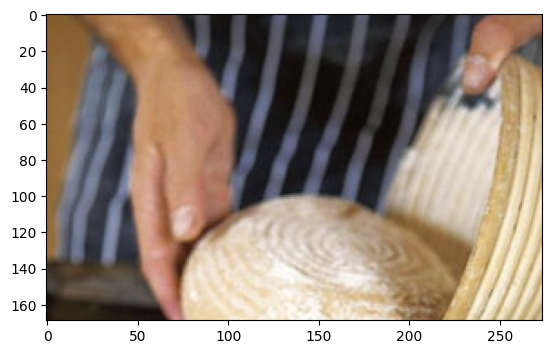

In [ ]:
showresult(names[3])

cold-soba-noodles-51262810.jpg
{'actual': ['oil', 'garlic', 'pepper', 'vinegar', 'rice'], 'prediction': ['oil', 'garlic', 'salt', 'pepper']}


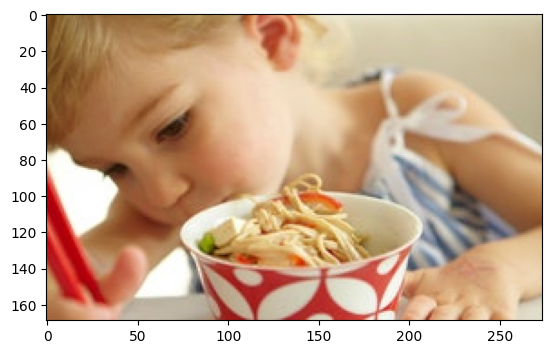

In [ ]:
showresult(names[4])

chocolate-dipped-salted-caramel-marshmallows-51151820.jpg
{'actual': ['chocolate', 'oil', 'salt'], 'prediction': ['pepper', 'egg', 'onion']}


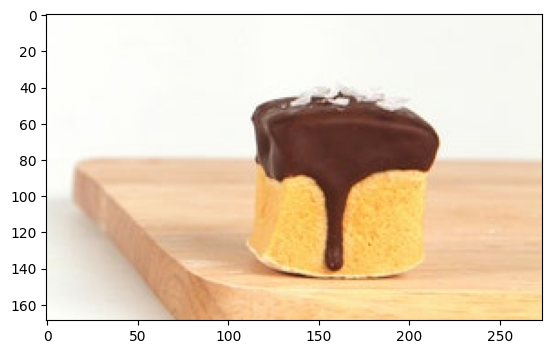

In [ ]:
showresult(names[5])

# New Data

In [ ]:
imgs = []
for root, dirs, files in os.walk("/content/gdrive/MyDrive/data/new_50"):
  for filename in files[:50]:
    photo = cv2.imread(os.path.join(root, filename))
    if(type(photo) != np.ndarray):
        continue
    if len(photo.shape) == 1:
      photo = cv2.cvtColor(photo, cv2.COLOR_GRAY2RGB)
    else:
      photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)
    photo = default_transform(photo)
    new_image_output = best(torch.unsqueeze(torch.tensor(photo), dim = 0)).squeeze().detach().numpy()
    for i in range(len(new_image_output)):
      if new_image_output[i] > 0.5:
        new_image_output[i] = 1
      else:
        new_image_output[i] = 0
    new_image_output, p = one_hot_to_label(new_image_output, [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], list(labels_set))
    print(filename + ": " + str(new_image_output))

<ipython-input-92-aeb66e4f8cf0>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_image_output = best(torch.unsqueeze(torch.tensor(photo), dim = 0)).squeeze().detach().numpy()


Garlic and Lemon Roasted Chicken.jpg: ['oil', 'salt', 'pepper', 'rice']
Onion and Tomato Frittata.jpg: ['oil', 'salt', 'pepper']
Vinegar Coleslaw.jpg: ['oil', 'salt', 'pepper']
Chicken Caesar Salad.jpg: ['oil', 'pepper', 'egg']
Lemon Pepper Salmon.jpg: ['oil', 'garlic', 'lemon', 'salt', 'pepper', 'rice']
Garlic Butter Shrimp Scampi.jpg: ['oil', 'salt', 'pepper', 'rice']
Tomato and Onion Omelette.jpg: ['oil', 'lemon', 'salt', 'pepper']
Garlic Mashed Potatoes .jpg: ['oil', 'salt', 'pepper']
Lemon and Herb Roasted Potatoes.jpg: ['oil', 'salt', 'pepper']
Chocolate Chip Banana Bread.jpg: ['oil', 'salt', 'pepper']
Chicken and Rice Casserole.jpg: ['oil', 'salt', 'pepper']
Lemon Garlic Roasted Broccoli.jpg: ['oil', 'lemon', 'egg']
Potato Salad.jpg: ['oil', 'pepper']
Tomato and Mozzarella Salad.jpg: ['oil', 'salt', 'pepper', 'rice']
Garlic Bread.jpg: ['oil', 'lemon', 'egg']
Lemon Pepper Chicken Wings .jpg: ['oil', 'egg']
Rice Pudding.jpg: ['oil', 'pepper']
Chicken and Vegetable Stir Fry .jpg: [

In [ ]:
import ast
path = "/content/drive/MyDrive/data/new_50"
res = "Garlic and Lemon Roasted Chicken.jpg: ['oil', 'salt', 'pepper', 'rice']\nOnion and Tomato Frittata.jpg: ['oil', 'salt', 'pepper']\nVinegar Coleslaw.jpg: ['oil', 'salt', 'pepper']\nChicken Caesar Salad.jpg: ['oil', 'pepper', 'egg']\nLemon Pepper Salmon.jpg: ['oil', 'garlic', 'lemon', 'salt', 'pepper', 'rice']\nGarlic Butter Shrimp Scampi.jpg: ['oil', 'salt', 'pepper', 'rice']\nTomato and Onion Omelette.jpg: ['oil', 'lemon', 'salt', 'pepper']\nGarlic Mashed Potatoes .jpg: ['oil', 'salt', 'pepper']\nLemon and Herb Roasted Potatoes.jpg: ['oil', 'salt', 'pepper']\nChocolate Chip Banana Bread.jpg: ['oil', 'salt', 'pepper']\nChicken and Rice Casserole.jpg: ['oil', 'salt', 'pepper']\nLemon Garlic Roasted Broccoli.jpg: ['oil', 'lemon', 'egg']\nPotato Salad.jpg: ['oil', 'pepper']\nTomato and Mozzarella Salad.jpg: ['oil', 'salt', 'pepper', 'rice']\nGarlic Bread.jpg: ['oil', 'lemon', 'egg']\nLemon Pepper Chicken Wings .jpg: ['oil', 'egg']\nRice Pudding.jpg: ['oil', 'pepper']\nChicken and Vegetable Stir Fry .jpg: ['oil', 'salt', 'pepper']\nOnion Soup.jpg: ['oil', 'salt', 'pepper']\nLemon Butter Chicken.jpg: ['oil', 'garlic', 'salt', 'pepper', 'rice']\nChocolate Brownies.jpg: ['oil', 'salt', 'pepper']\nGarlic and Herb Roasted Pork Tenderloin.jpg: ['oil', 'salt', 'pepper', 'rice']\nTomato Soup.jpg: ['oil', 'salt', 'pepper']\nGarlic Shrimp Alfredo Pasta.jpg: ['oil', 'egg']\nLemon and Herb Marinated Chicken.jpg: ['oil', 'garlic', 'salt', 'pepper', 'rice']\nPotatoes Au Gratin .jpg: ['oil', 'salt', 'pepper']\nChocolate Truffles.jpg: ['oil', 'salt', 'pepper']\nGarlic and Herb Roasted Vegetables.jpg: ['oil', 'salt', 'pepper', 'rice']\nLemon and Garlic Roasted Asparagus.jpg: ['oil', 'salt', 'pepper']\nChicken and Broccoli Alfredo.jpg: ['oil', 'salt', 'pepper']\nOnion Rings.jpg: ['oil', 'garlic', 'salt', 'pepper', 'rice']\nTomato Bruschetta.jpg: ['oil', 'salt', 'pepper']\nGarlic and Herb Baked Chicken Thighs.jpg: ['oil', 'salt', 'pepper', 'rice']\nLemon and Garlic Shrimp Skewers.jpg: ['oil', 'salt', 'pepper']\nChicken Enchiladas.jpg: ['oil', 'garlic', 'salt', 'pepper']\nChocolate Fondue.jpg: ['oil', 'garlic', 'salt', 'pepper']\nGarlic and Lemon Roasted Potatoes.jpg: ['oil', 'pepper']\nTomato and Cucumber Salad .jpg: ['oil', 'garlic', 'salt', 'pepper', 'rice']\nLemon Pepper Tuna Salad.jpg: ['oil', 'salt', 'pepper']\nRice and Beans.jpg: ['oil', 'garlic', 'salt', 'pepper', 'rice']\nGarlic and Herb Crusted Baked Salmon.jpg: ['oil', 'salt', 'pepper', 'rice']\nLemon and Garlic Roasted Brussels Sprouts.jpg: ['oil', 'garlic', 'salt', 'pepper', 'rice']\nChicken Alfredo Pasta.jpg: ['oil', 'salt', 'pepper']\nPotato Soup.jpg: ['oil', 'garlic', 'salt', 'pepper', 'rice']\nChocolate Mousse.jpg: ['oil', 'salt', 'pepper']\nGarlic and Herb Roasted Lamb Chops.jpg: ['oil', 'garlic', 'salt', 'pepper', 'rice']\nLemon Pepper Roasted Cauliflower.jpg: ['oil', 'lemon', 'salt', 'pepper', 'rice']\nChicken and Mushroom Risotto.jpg: ['oil', 'salt', 'pepper', 'rice']\nOnion and Cheese Tart.jpg: ['oil', 'garlic', 'salt', 'pepper', 'rice']\nGarlic and Lemon Grilled Shrimp.jpg: ['oil', 'salt', 'pepper', 'rice']"
items = res.split("\n")
file = []
pred_ing = []
for item in items:
  file.append(item.split(": ")[0])
  pred_ing.append(ast.literal_eval(item.split(": ")[1]))

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/New_Data.csv")
names = list(df["Dish Name"])
ingr = list(df["Present Ingredients"])
for i in range(len(ingr)):
  output_list = ingr[i].strip('[]').replace(' ', '').split(',')
  output_list = [item.strip("'") for item in output_list]
  output_list[0] = output_list[0].lower()
  ingr[i] = output_list
ingr

[['garlic', 'lemon', 'chicken', 'oil', 'salt', 'pepper'],
 ['onion', 'tomato', 'eggs', 'oil', 'salt', 'pepper'],
 ['vinegar', 'oil', 'salt', 'pepper'],
 ['chicken', 'eggs', 'oil', 'lemon', 'salt', 'pepper'],
 ['lemon', 'pepper', 'oil', 'salt'],
 ['garlic', 'oil', 'salt', 'pepper', 'lemon'],
 ['tomato', 'onion', 'eggs', 'oil', 'salt', 'pepper'],
 ['garlic', 'potatoes', 'milk', 'salt', 'pepper'],
 ['lemon', 'potatoes', 'oil', 'salt', 'pepper'],
 ['chocolate', 'eggs', 'oil', 'salt'],
 ['chicken', 'rice', 'onions', 'garlic', 'oil', 'salt', 'pepper'],
 ['lemon', 'garlic', 'oil', 'salt', 'pepper'],
 ['potatoes', 'onion', 'eggs', 'oil', 'vinegar', 'salt', 'pepper'],
 ['tomato', 'vinegar', 'oil', 'salt', 'pepper'],
 ['garlic', 'bread', 'oil', 'salt'],
 ['lemon', 'pepper', 'chicken', 'oil', 'salt'],
 ['rice', 'milk', 'salt'],
 ['chicken', 'oil', 'salt', 'pepper'],
 ['onion', 'bread', 'salt', 'pepper'],
 ['lemon', 'chicken', 'oil', 'salt', 'pepper'],
 ['chocolate', 'eggs', 'oil', 'salt'],
 ['gar

In [ ]:
a = set()
for e in ingr:
  for r in e:
    a.add(r)
len(a)
a = list(a)

In [ ]:
right = 0
total = 0
for i in range(len(file)):
  for e in a:
    if e in pred_ing[i] and e in ingr[i] or e not in pred_ing[i] and e not in ingr[i]:
      right += 1
    total += 1
right/total

0.81375

# Past Models

In [ ]:
# similar to VGG architecture: https://blog.paperspace.com/vgg-from-scratch-pytorch/, but scaled down
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.name = "APS360"
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 3, 160, 160 to 32, 160, 160
            nn.MaxPool2d(kernel_size = 2, stride = 2))
            # 32, 160, 160 to 32, 80, 80

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 32, 80, 80 to 64, 80, 80
            nn.MaxPool2d(kernel_size = 2, stride = 2))
            # 64, 80, 80 to 64, 40, 40

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 64, 40, 40 to 128, 40, 40
            nn.MaxPool2d(kernel_size = 2, stride = 2))
            # 128, 40, 40 to 128, 20, 20


        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(20*20*128, 50),
            nn.ReLU())

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(50, 50),
            nn.ReLU())

        self.fc2 = nn.Sequential(
            nn.Linear(50, len(np.array(list(labels_set)))),
            nn.Sigmoid())


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
class resnet(nn.Module):
    def __init__(self, num_classes):
        super(resnet, self).__init__()
        self.name = "APS360v2"
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 3, 160, 160 to 32, 160, 160
            nn.MaxPool2d(kernel_size = 2, stride = 2))
            # 32, 160, 160 to 32, 80, 80

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 32, 80, 80 to 64, 80, 80
            nn.MaxPool2d(kernel_size = 2, stride = 2))
            # 64, 80, 80 to 64, 40, 40
        self.downsample = nn.Conv2d(64, 64, kernel_size=4, stride=3, padding=0)
            # 64, 40, 40 to 64, 17, 17

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64))
            # 64, 40, 40 to 64, 40, 40

        self.layer4 = nn.Sequential(nn.ReLU(), nn.AvgPool2d(kernel_size = 4, stride = 3))
            # 64, 40, 40 to 64, 17, 17

        self.fc = nn.Sequential(
            nn.Linear(13*13*64, len(np.array(list(labels_set)))),
            nn.Sigmoid())


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        residual = self.downsample(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = out + residual

        out = out.reshape(out.size(0), -1)

        out = self.fc(out)

        return out

In [ ]:
# similar to VGG architecture: https://blog.paperspace.com/vgg-from-scratch-pytorch/, but scaled down

class CNNV2(nn.Module):
    def __init__(self, num_classes):
        super(CNNV2, self).__init__()
        self.name = "APS360_CNNV2"
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            # 3, 160, 160 to 64, 160, 160
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            # 64, 160, 160 to 64, 160, 160
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 64, 160, 160 to 64, 80, 80
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            # 64, 80, 80 to 128, 80, 80
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            # 128, 80, 80 to 128, 80, 80
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 128, 80, 80 to 128, 40, 40
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            # 128, 40, 40 to 256, 40, 40
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            # 256, 40, 40 to 256, 40, 40
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # 256, 40, 40 to 256, 20, 20
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(20*20*256, 25),
            nn.ReLU())

        # self.fc1 = nn.Sequential(
        #     nn.Dropout(0.3),
        #     nn.Linear(25, 25),
        #     nn.ReLU())

        self.fc2 = nn.Sequential(
            nn.Linear(25, len(np.array(list(labels_set)))),
            nn.Sigmoid())


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        # out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
# similar to VGG architecture: https://blog.paperspace.com/vgg-from-scratch-pytorch/, but scaled down

class CNNV3(nn.Module):
    def __init__(self, num_classes):
        super(CNNV3, self).__init__()
        self.name = "APS360_CNNV3"
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            # 3, 160, 160 to 64, 160, 160
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            # 64, 160, 160 to 64, 160, 160
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 64, 160, 160 to 64, 80, 80
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            # 64, 80, 80 to 128, 80, 80
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            # 128, 80, 80 to 128, 80, 80
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 128, 80, 80 to 128, 40, 40
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        # self.layer5 = nn.Sequential(
        #     nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        #     # 128, 40, 40 to 256, 40, 40
        #     nn.BatchNorm2d(256),
        #     nn.ReLU())

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(40*40*128, 25),
            nn.ReLU())

        # self.fc1 = nn.Sequential(
        #     nn.Dropout(0.3),
        #     nn.Linear(25, 25),
        #     nn.ReLU())

        self.fc2 = nn.Sequential(
            nn.Linear(25, len(np.array(list(labels_set)))),
            nn.Sigmoid())


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        # out = self.fc1(out)
        out = self.fc2(out)
        return out

# Training History

CUDA is available!  Training on GPU ...
Epoch 1:  Train loss: 7.125273310962846,  Train acc: 0.7522058823529412| Validation loss: 3.3622132301330567, Validation acc: 0.7647587719298247
Epoch 2:  Train loss: 2.091675819719539,  Train acc: 0.7842754289215687| Validation loss: 1.9681753396987915, Validation acc: 0.7847176535087719
Epoch 3:  Train loss: 1.1607225234894192,  Train acc: 0.7910079656862742| Validation loss: 0.4883426696062088, Validation acc: 0.7877412280701754
Epoch 4:  Train loss: 0.45921554065802517,  Train acc: 0.7979702818627449| Validation loss: 0.4511350005865097, Validation acc: 0.8005372807017543
Epoch 5:  Train loss: 0.44809707297998314,  Train acc: 0.8022824754901959| Validation loss: 0.45018007457256315, Validation acc: 0.8007291666666667
Epoch 6:  Train loss: 0.444156053749954,  Train acc: 0.8028875612745099| Validation loss: 0.4498842179775238, Validation acc: 0.8006770833333332
Epoch 7:  Train loss: 0.43904348112204494,  Train acc: 0.8037454044117649| Validatio

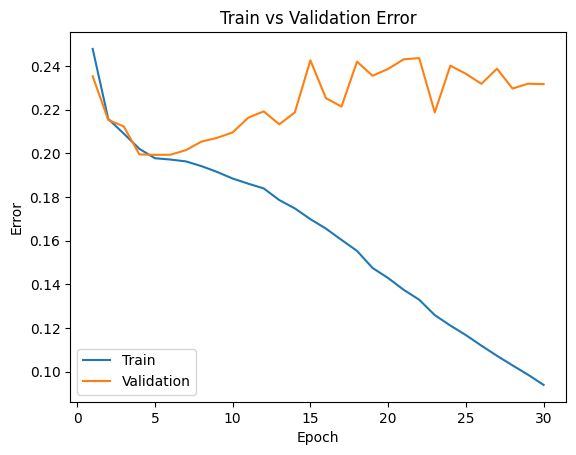

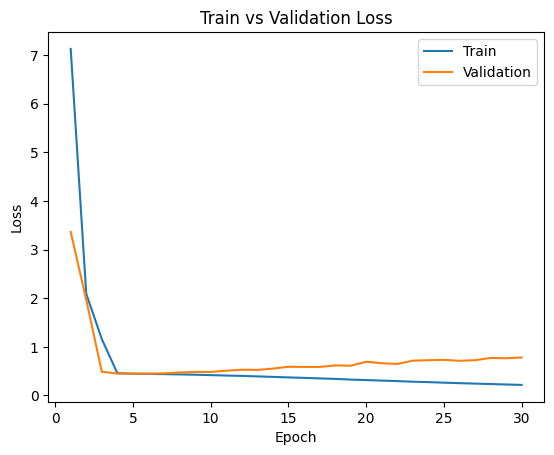

In [ ]:
use_cuda = True
CNNV3_003_128_30 = CNNV3(15)
if use_cuda and torch.cuda.is_available():
  CNNV3_003_128_30.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(CNNV3_003_128_30, train_set, valid_set, learning_rate = 0.003, batch_size = 128, num_epochs= 30, plot = True)

CUDA is available!  Training on GPU ...
Epoch 1:  Train loss: 6.434063322403851,  Train acc: 0.7499463848039215| Validation loss: 2.81011221408844, Validation acc: 0.7846765350877193
Epoch 2:  Train loss: 2.303562625366099,  Train acc: 0.7900352328431376| Validation loss: 2.1592912077903748, Validation acc: 0.7801069078947369
Epoch 3:  Train loss: 1.3431054940995049,  Train acc: 0.7872549019607844| Validation loss: 0.6487035304307938, Validation acc: 0.7745696271929824
Epoch 4:  Train loss: 0.5018172939034069,  Train acc: 0.7917356004901959| Validation loss: 0.48586039841175077, Validation acc: 0.7938075657894736
Epoch 5:  Train loss: 0.47644307508188133,  Train acc: 0.7985217524509801| Validation loss: 0.4683294028043747, Validation acc: 0.7960855263157894
Epoch 6:  Train loss: 0.46165598008562536,  Train acc: 0.8014705882352944| Validation loss: 0.4640446066856384, Validation acc: 0.8000493421052631
Epoch 7:  Train loss: 0.45304850839516697,  Train acc: 0.8024433210784313| Validation

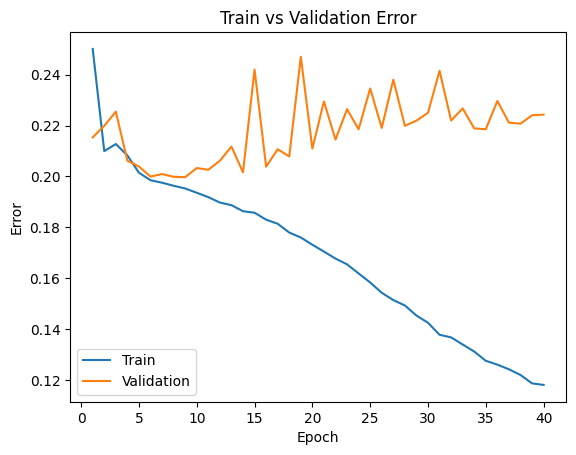

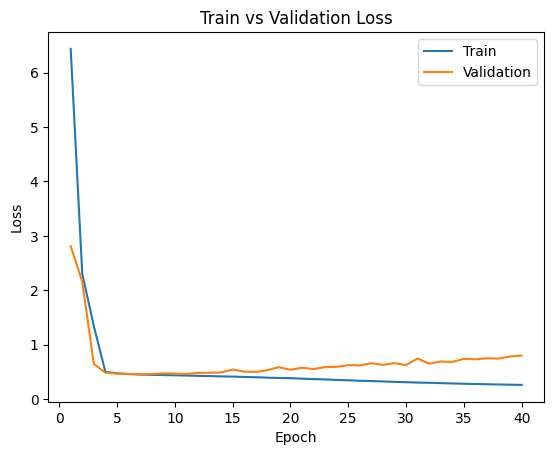

In [ ]:
use_cuda = True
CNNV3_004_128_40 = CNNV3(15)
if use_cuda and torch.cuda.is_available():
  CNNV3_004_128_40.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(CNNV3_004_128_40, train_set, valid_set, learning_rate = 0.004, batch_size = 128, num_epochs= 40, plot = True)

CUDA is available!  Training on GPU ...
Epoch 1:  Train loss: 7.798829189118217,  Train acc: 0.7725030637254902| Validation loss: 4.577999377250672, Validation acc: 0.7592790570175438
Epoch 2:  Train loss: 2.6732139587402344,  Train acc: 0.7887101715686275| Validation loss: 3.1645439505577087, Validation acc: 0.7699561403508772
Epoch 3:  Train loss: 1.5498322572778254,  Train acc: 0.7920266544117649| Validation loss: 0.862167239189148, Validation acc: 0.760970394736842
Epoch 4:  Train loss: 0.5091069739531068,  Train acc: 0.7984987745098039| Validation loss: 0.4634331911802292, Validation acc: 0.8003097587719299
Epoch 5:  Train loss: 0.45099672236863303,  Train acc: 0.8013327205882351| Validation loss: 0.46073360443115235, Validation acc: 0.8002412280701755
Epoch 6:  Train loss: 0.4486115605515592,  Train acc: 0.802113970588235| Validation loss: 0.4611021399497986, Validation acc: 0.801027960526316
Epoch 7:  Train loss: 0.44629086554050446,  Train acc: 0.8031862745098038| Validation lo

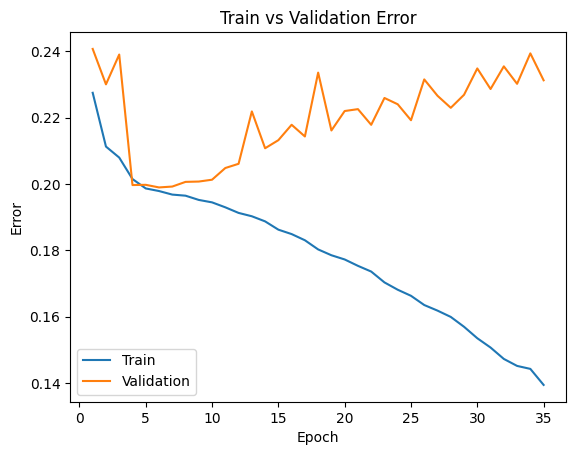

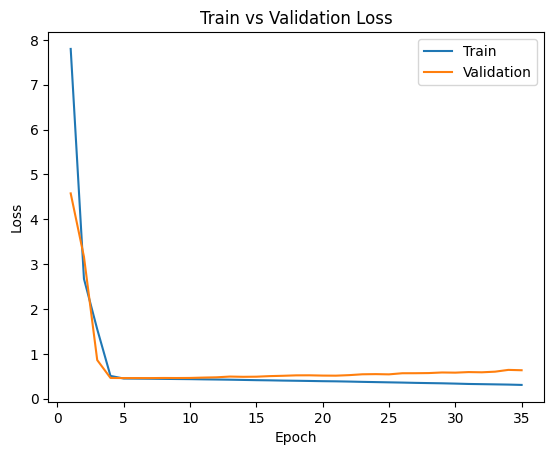

In [ ]:
use_cuda = True
CNNV3_005_128_35 = CNNV3(15)
if use_cuda and torch.cuda.is_available():
  CNNV3_005_128_35.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  #added training data
train(CNNV3_005_128_35, train_set, valid_set, learning_rate = 0.005, batch_size = 128, num_epochs= 35, plot = True)

Epoch 1:  Train loss: 0.5176299166035008,  Train acc: 0.7563250750750752| Validation loss: 0.5200477734855984, Validation acc: 0.7543284161490683
Epoch 2:  Train loss: 0.5147545243705716,  Train acc: 0.7580129236379235| Validation loss: 0.5225279719933219, Validation acc: 0.7541343167701864
Epoch 3:  Train loss: 0.5139361512553584,  Train acc: 0.7577756327756332| Validation loss: 0.5229860803355342, Validation acc: 0.7545225155279504
Epoch 4:  Train loss: 0.5117071483049307,  Train acc: 0.7590183933933934| Validation loss: 0.5219806756662286, Validation acc: 0.7535520186335404
Epoch 5:  Train loss: 0.5126190287572844,  Train acc: 0.7582944551694552| Validation loss: 0.5203987930131995, Validation acc: 0.7532608695652175
Epoch 6:  Train loss: 0.5118844109075563,  Train acc: 0.7589205276705282| Validation loss: 0.5197603197201438, Validation acc: 0.7547166149068323
Epoch 7:  Train loss: 0.5096450187601484,  Train acc: 0.759458118833119| Validation loss: 0.5203978069450544, Validation acc

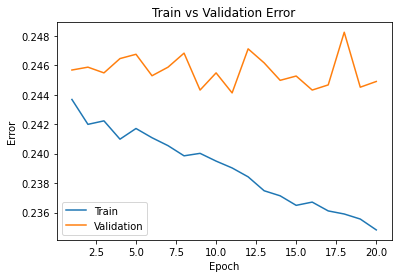

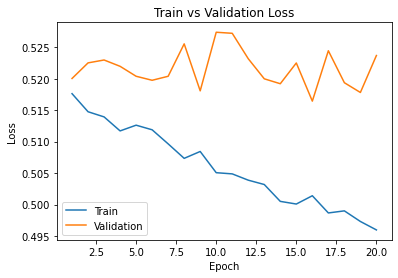

In [ ]:
use_cuda = True
CNNV1_005_64_20 = CNN(15)
if use_cuda and torch.cuda.is_available():
  CNNV1_005_64_20.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(CNNV1_005_64_20, train_set, valid_set, learning_rate = 0.005, batch_size = 64, num_epochs= 20, plot = True)

CUDA is available!  Training on GPU ...
Epoch 1:  Train loss: 78.56492680178748,  Train acc: 0.2094212962962964| Validation loss: 79.83854598999024, Validation acc: 0.20161458333333332
Epoch 2:  Train loss: 79.70448009349681,  Train acc: 0.20295524691358036| Validation loss: 79.83854598999024, Validation acc: 0.20161458333333332
Epoch 3:  Train loss: 79.70448009349681,  Train acc: 0.20295524691358036| Validation loss: 79.83854598999024, Validation acc: 0.20161458333333332
Epoch 4:  Train loss: 79.70448009349681,  Train acc: 0.20295524691358036| Validation loss: 79.83854598999024, Validation acc: 0.20161458333333332
Epoch 5:  Train loss: 79.70448009349681,  Train acc: 0.20295524691358036| Validation loss: 79.83854598999024, Validation acc: 0.20161458333333332
Epoch 6:  Train loss: 79.70448009349681,  Train acc: 0.20295524691358036| Validation loss: 79.83854598999024, Validation acc: 0.20161458333333332
Epoch 7:  Train loss: 79.70448009349681,  Train acc: 0.20295524691358036| Validation 

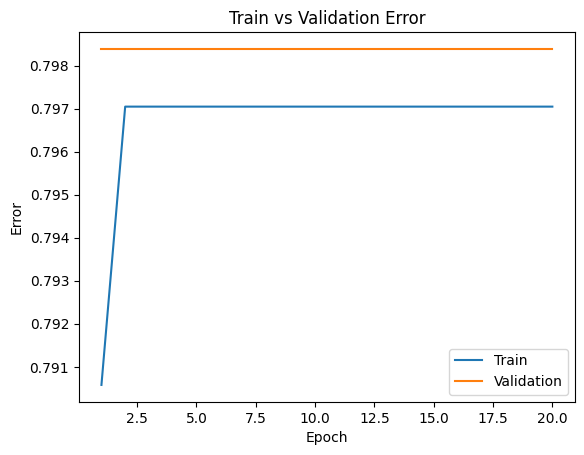

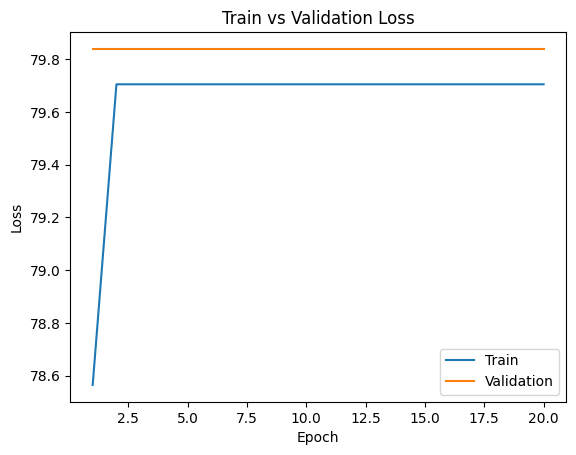

In [ ]:
use_cuda = True
RESV1_005_64_20 = resnet(15)
if use_cuda and torch.cuda.is_available():
  RESV1_005_64_20.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(RESV1_005_64_20, train_set, valid_set, learning_rate = 0.005, batch_size = 64, num_epochs= 20, plot = True)

CUDA is available!  Training on GPU ...
Epoch 1:  Train loss: 77.3400013314353,  Train acc: 0.22131172839506166| Validation loss: 78.86285209655762, Validation acc: 0.21137152777777776
Epoch 2:  Train loss: 78.5054063019929,  Train acc: 0.2149459876543209| Validation loss: 78.86285209655762, Validation acc: 0.21137152777777776
Epoch 3:  Train loss: 78.5054063019929,  Train acc: 0.2149459876543209| Validation loss: 78.86285209655762, Validation acc: 0.21137152777777776
Epoch 4:  Train loss: 78.5054063019929,  Train acc: 0.2149459876543209| Validation loss: 78.86285209655762, Validation acc: 0.21137152777777776
Epoch 5:  Train loss: 78.5054063019929,  Train acc: 0.2149459876543209| Validation loss: 78.86285209655762, Validation acc: 0.21137152777777776
Epoch 6:  Train loss: 78.5054063019929,  Train acc: 0.2149459876543209| Validation loss: 78.86285209655762, Validation acc: 0.21137152777777776
Epoch 7:  Train loss: 78.5054063019929,  Train acc: 0.2149459876543209| Validation loss: 78.862

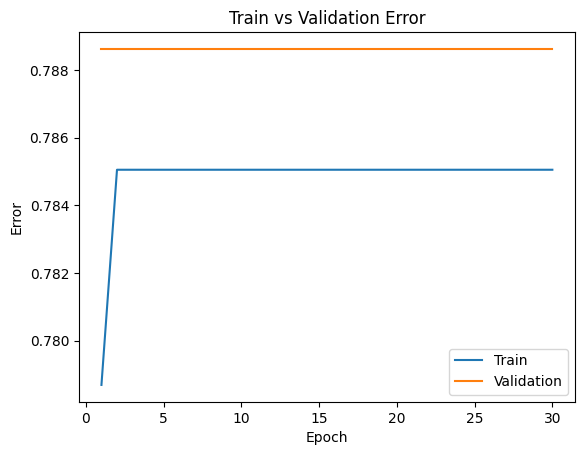

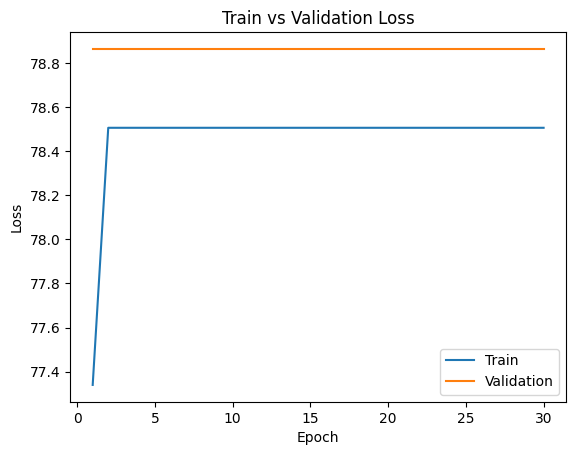

In [ ]:
use_cuda = True
RESV1_01_64_30 = resnet(15)
if use_cuda and torch.cuda.is_available():
  RESV1_01_64_30.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(RESV1_01_64_30, train_set, valid_set, learning_rate = 0.01, batch_size = 64, num_epochs= 30, plot = True)

CUDA is available!  Training on GPU ...
Epoch 1:  Train loss: 1.2720607358505291,  Train acc: 0.7946871127633207| Validation loss: 0.4477305144835741, Validation acc: 0.8012998575498573
Epoch 2:  Train loss: 0.4509627832355996,  Train acc: 0.8009138785625771| Validation loss: 0.44738970200220746, Validation acc: 0.8012998575498573
Epoch 3:  Train loss: 0.4509355701700019,  Train acc: 0.8009835811648076| Validation loss: 0.44739572283549184, Validation acc: 0.8012998575498573
Epoch 4:  Train loss: 0.45098179944385824,  Train acc: 0.8009293680297395| Validation loss: 0.447387281136635, Validation acc: 0.8012998575498573
Epoch 5:  Train loss: 0.450899851809647,  Train acc: 0.8009448574969017| Validation loss: 0.4473484930319664, Validation acc: 0.8012998575498573
Epoch 6:  Train loss: 0.4509772284988134,  Train acc: 0.8008751548946713| Validation loss: 0.44728191922872496, Validation acc: 0.8012998575498573
Epoch 7:  Train loss: 0.4510697222775243,  Train acc: 0.8009216232961581| Validati

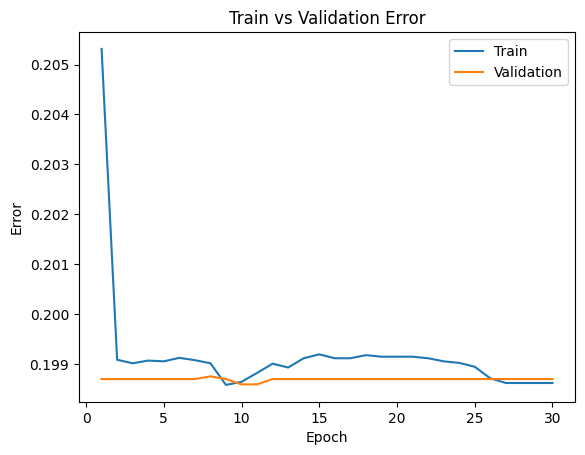

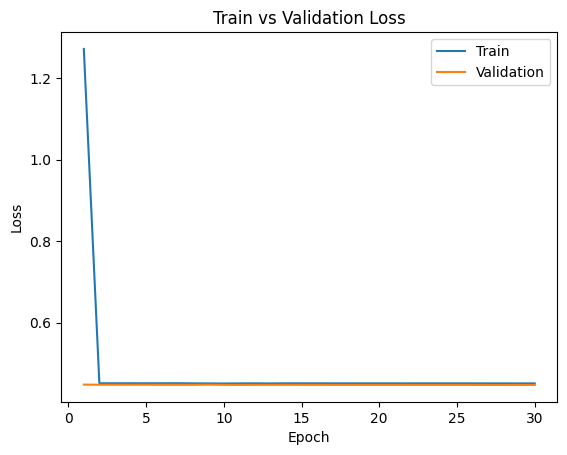

In [ ]:
use_cuda = True
CNNV1_01_32_30 = CNN(15)
if use_cuda and torch.cuda.is_available():
  CNNV1_01_32_30.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(CNNV1_01_32_30, train_set, valid_set, learning_rate = 0.01, batch_size = 32, num_epochs= 30, plot = True)

CUDA is available!  Training on GPU ...
Epoch 1:  Train loss: 4.008804294135835,  Train acc: 0.7811188271604942| Validation loss: 0.46744743436574937, Validation acc: 0.7957986111111109
Epoch 2:  Train loss: 0.46409342090288797,  Train acc: 0.799135802469136| Validation loss: 0.45454656183719633, Validation acc: 0.8012152777777779
Epoch 3:  Train loss: 0.4544701249511154,  Train acc: 0.8011728395061727| Validation loss: 0.4506927222013474, Validation acc: 0.8010243055555554
Epoch 4:  Train loss: 0.4511244546484064,  Train acc: 0.8013425925925923| Validation loss: 0.4492477536201477, Validation acc: 0.8010763888888889
Epoch 5:  Train loss: 0.4491122018407892,  Train acc: 0.8014043209876544| Validation loss: 0.4481667667627335, Validation acc: 0.8016145833333332
Epoch 6:  Train loss: 0.4471923413100066,  Train acc: 0.801929012345679| Validation loss: 0.449946728348732, Validation acc: 0.8028125000000002
Epoch 7:  Train loss: 0.44551130268308853,  Train acc: 0.8020987654320987| Validation

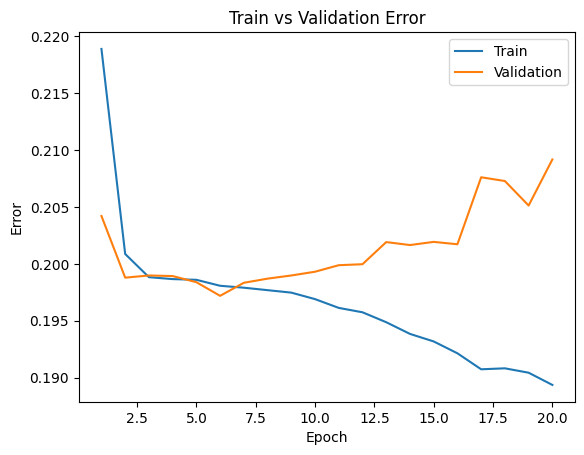

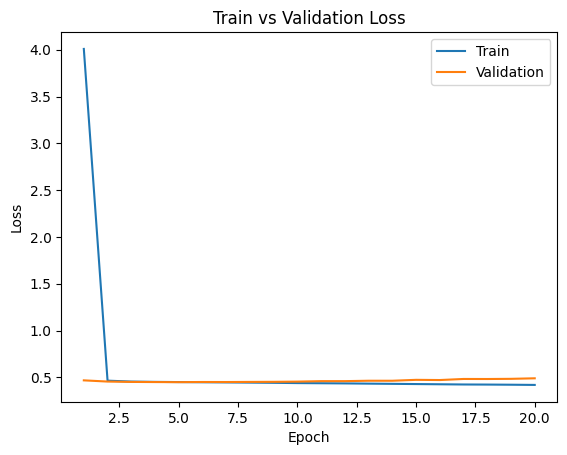

In [ ]:
use_cuda = True
CNNV2_01_64_20 = CNNV2(15)
if use_cuda and torch.cuda.is_available():
  CNNV2_01_64_20.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(CNNV2_01_64_20, train_set, valid_set, learning_rate = 0.01, batch_size = 64, num_epochs= 20, plot = True)

CUDA is available!  Training on GPU ...
Epoch 1:  Train loss: 5.586035724039431,  Train acc: 0.7806944444444447| Validation loss: 0.4511464715003967, Validation acc: 0.8009201388888888
Epoch 2:  Train loss: 0.4508026017083062,  Train acc: 0.801496913580247| Validation loss: 0.4463661715388298, Validation acc: 0.8010763888888889
Epoch 3:  Train loss: 0.44898180851229913,  Train acc: 0.8014120370370369| Validation loss: 0.4457609459757805, Validation acc: 0.8008506944444443
Epoch 4:  Train loss: 0.4479881487510822,  Train acc: 0.8016975308641976| Validation loss: 0.44581588059663774, Validation acc: 0.8026736111111109
Epoch 5:  Train loss: 0.4461984669720685,  Train acc: 0.8016898148148148| Validation loss: 0.4453071877360344, Validation acc: 0.8025520833333333
Epoch 6:  Train loss: 0.4454733270185965,  Train acc: 0.8028240740740744| Validation loss: 0.4462707072496414, Validation acc: 0.8007638888888888
Epoch 7:  Train loss: 0.44433407717280915,  Train acc: 0.8036111111111109| Validatio

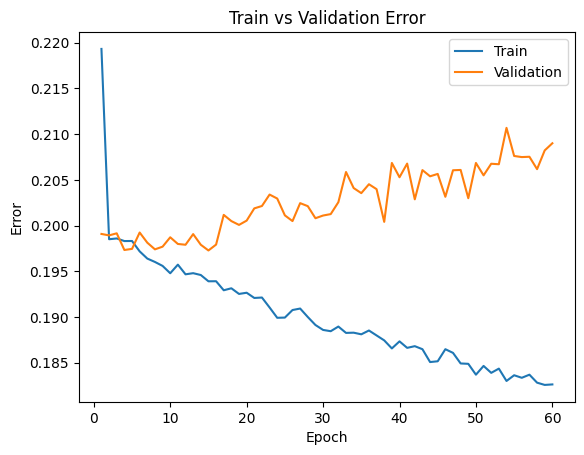

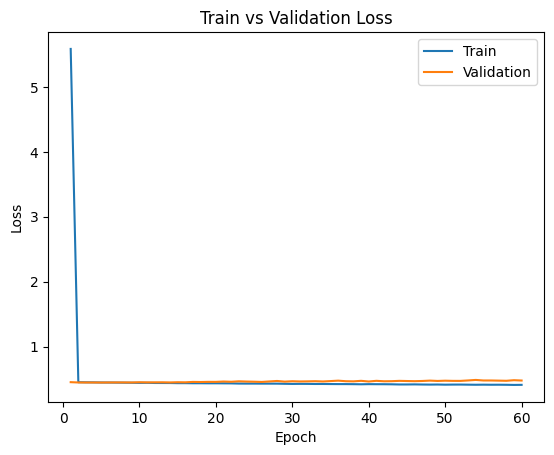

In [ ]:
use_cuda = True
CNNV2_01_64_60 = CNNV2(15)
if use_cuda and torch.cuda.is_available():
  CNNV2_01_64_60.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(CNNV2_01_64_60, train_set, valid_set, learning_rate = 0.01, batch_size = 64, num_epochs= 60, plot = True)

CUDA is available!  Training on GPU ...
Epoch 1:  Train loss: 0.6915958428824389,  Train acc: 0.7333564814814817| Validation loss: 0.5083458676934243, Validation acc: 0.7998611111111111
Epoch 2:  Train loss: 0.4821763252770459,  Train acc: 0.7982175925925925| Validation loss: 0.4729354739189148, Validation acc: 0.7999131944444445
Epoch 3:  Train loss: 0.46511910292837355,  Train acc: 0.7991975308641976| Validation loss: 0.4605302706360817, Validation acc: 0.800017361111111
Epoch 4:  Train loss: 0.4561695061348103,  Train acc: 0.7995601851851851| Validation loss: 0.452253557741642, Validation acc: 0.7971180555555556
Epoch 5:  Train loss: 0.4502109063996209,  Train acc: 0.8002546296296293| Validation loss: 0.44539213329553606, Validation acc: 0.8028993055555557
Epoch 6:  Train loss: 0.4458563926043334,  Train acc: 0.8024382716049384| Validation loss: 0.44350379705429077, Validation acc: 0.8024652777777778
Epoch 7:  Train loss: 0.4446107193275734,  Train acc: 0.8029475308641977| Validatio

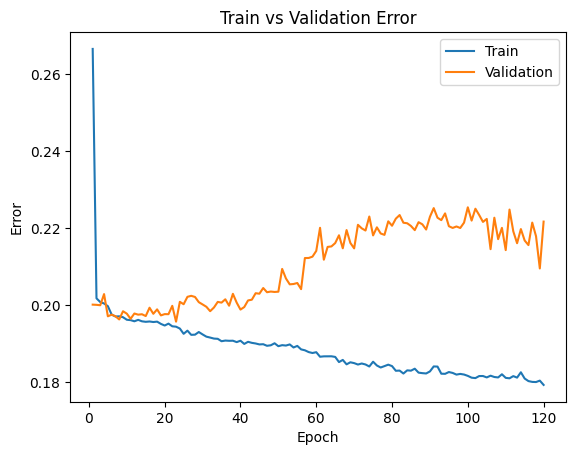

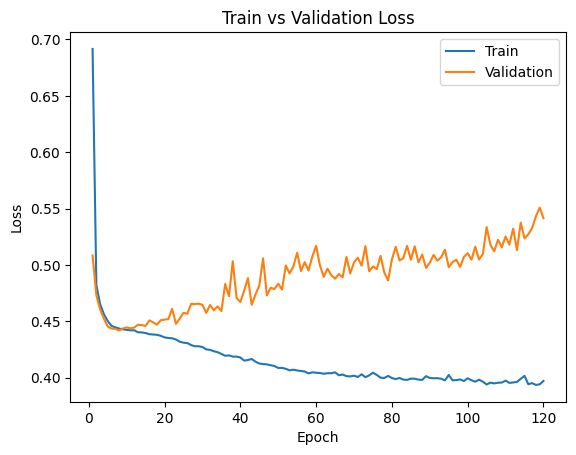

In [ ]:
use_cuda = True
CNNV2_01_64_120 = CNNV2(15)
if use_cuda and torch.cuda.is_available():
  CNNV2_01_64_120.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
#Trained with NADAM, significantly slower than adam, seemed to get stuck "
train(CNNV2_01_64_120, train_set, valid_set, learning_rate = 0.002, batch_size = 64, num_epochs= 120, plot = True)

In [ ]:
use_cuda = True
CNNV2_01_128_80 = CNNV2(15)
if use_cuda and torch.cuda.is_available():
  CNNV2_01_128_80.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(CNNV2_01_128_80, train_set, valid_set, learning_rate = 0.01, batch_size = 128, num_epochs= 80, plot = True)

CUDA is available!  Training on GPU ...


OutOfMemoryError: ignored

CUDA is available!  Training on GPU ...
Epoch 1:  Train loss: 2.758568799671005,  Train acc: 0.7559512867647059| Validation loss: 1.223473811149597, Validation acc: 0.7713733552631579
Epoch 2:  Train loss: 0.6953242982135099,  Train acc: 0.7815410539215688| Validation loss: 0.47695390582084657, Validation acc: 0.7870010964912281
Epoch 3:  Train loss: 0.4687812122351983,  Train acc: 0.7924862132352938| Validation loss: 0.46774475276470184, Validation acc: 0.7916721491228069
Epoch 4:  Train loss: 0.4626783022985739,  Train acc: 0.7953354779411766| Validation loss: 0.4678328424692154, Validation acc: 0.7923355263157894
Epoch 5:  Train loss: 0.45346393041750965,  Train acc: 0.7979856004901961| Validation loss: 0.4802959501743317, Validation acc: 0.7869846491228071
Epoch 6:  Train loss: 0.4484546793734326,  Train acc: 0.7997012867647058| Validation loss: 0.47448748648166655, Validation acc: 0.7878042763157895
Epoch 7:  Train loss: 0.442418457392384,  Train acc: 0.8013403799019606| Validatio

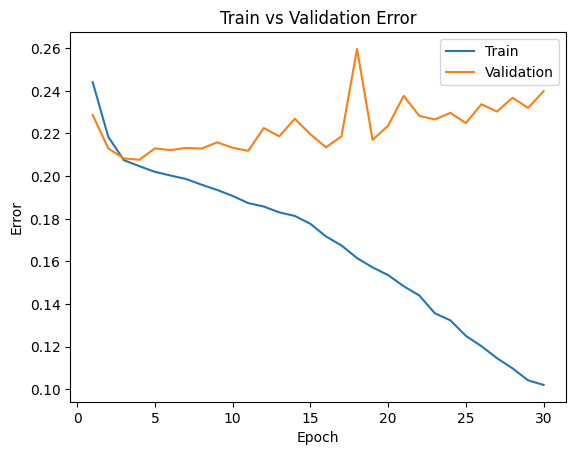

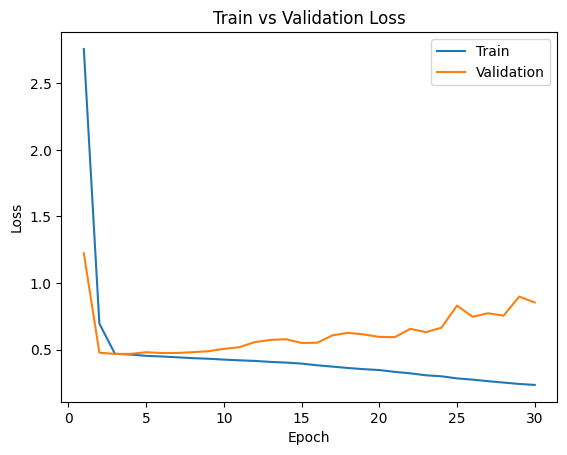

In [ ]:
use_cuda = True
CNNV2_003_64_60 = CNNV2(15)
if use_cuda and torch.cuda.is_available():
  CNNV2_003_64_60.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
#changed random seed, change drop out from 0.2 to 0.3 "
train(CNNV2_003_64_60, train_set, valid_set, learning_rate = 0.003, batch_size = 128, num_epochs= 30, plot = True)

CUDA is available!  Training on GPU ...
Epoch 1:  Train loss: 5.983384358882904,  Train acc: 0.768163580246913| Validation loss: 1.0573236644268036, Validation acc: 0.7765972222222223
Epoch 2:  Train loss: 0.48455091803162187,  Train acc: 0.7965354938271605| Validation loss: 0.4597111508250237, Validation acc: 0.8023784722222222
Epoch 3:  Train loss: 0.4504349724010185,  Train acc: 0.8012037037037039| Validation loss: 0.45732772946357725, Validation acc: 0.8014930555555555
Epoch 4:  Train loss: 0.44661758851121974,  Train acc: 0.8023225308641974| Validation loss: 0.4574225157499313, Validation acc: 0.7999479166666668
Epoch 5:  Train loss: 0.44286490855393584,  Train acc: 0.8039351851851855| Validation loss: 0.453677274286747, Validation acc: 0.8008506944444443
Epoch 6:  Train loss: 0.437632288535436,  Train acc: 0.8056635802469132| Validation loss: 0.45493498295545576, Validation acc: 0.8000868055555556
Epoch 7:  Train loss: 0.43157388236787586,  Train acc: 0.8069830246913575| Validati

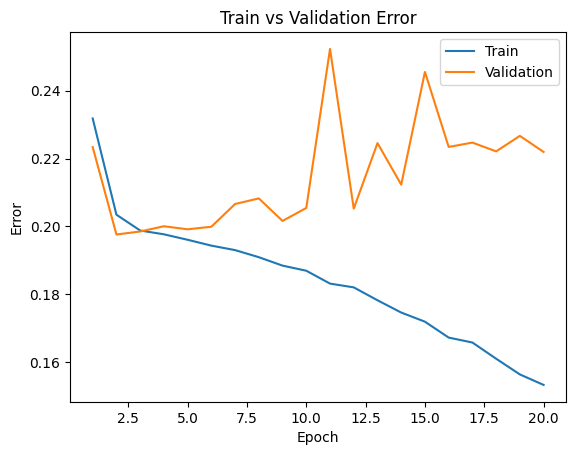

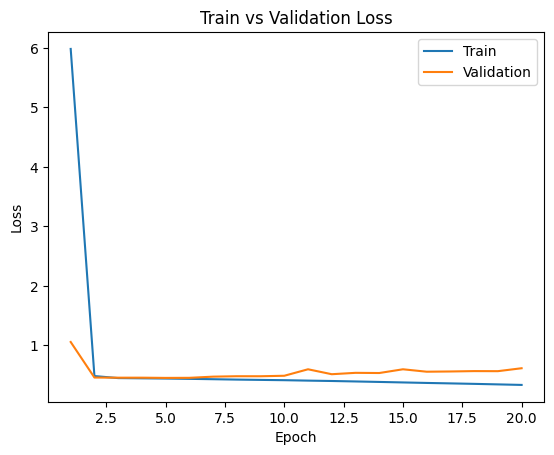

In [ ]:
use_cuda = True
CNNV3_004_64_20 = CNNV3(15)
if use_cuda and torch.cuda.is_available():
  CNNV3_004_64_20.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(CNNV3_004_64_20, train_set, valid_set, learning_rate = 0.004, batch_size = 64, num_epochs= 20, plot = True)

# Archive

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, root_path, labels_lookup, default_transform,
               augmentation_transform, augment=False):
    self.root_path = root_path
    self.photo_paths = [f for f in sorted(os.listdir(root_path))]
    self.labels = [os.path.basename(f) for f in sorted(os.listdir(root_path))]
    self.default_transform = default_transform
    self.augmentation_transform = augmentation_transform
    self.augment = augment
    self.labels_lookup = labels_lookup

  def __len__(self):
    return len(self.photo_paths)

  def __getitem__(self, idx):
    photo = cv2.imread(self.root_path + '/' + self.photo_paths[idx])
    if len(photo.shape) == 1:
      photo = cv2.cvtColor(photo, cv2.COLOR_GRAY2RGB)
    else:
      photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)


    img_name = self.labels[idx].replace(".jpg", "")
    label = self.labels_lookup.query(f"Image_Name=='{img_name}'")["Ingredients"]
    label = label.tolist()[0].strip('][').replace("'", "").split(', ')

    if self.augment:
      photo = self.augmentation_transform(photo)
    else:
      photo = self.default_transform(photo)

    return photo, label

# Compose transforms
default_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((160,160)),
    transforms.ToTensor()
])

augmentation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((160,160)),
    transforms.ColorJitter((0.8, 1.2),
                           (0.8, 1.2),
                           (0.8, 1.2)),
    transforms.RandomRotation((0, 360)),
    transforms.ToTensor()
])
labels_lookup = pd.read_csv("/content/gdrive/MyDrive/data/processed/simplified_labels.csv")

# Create datasets
def_train_set = Dataset("/content/gdrive/MyDrive/data/raw/training_images_simplified/",
                          labels_lookup,
                          default_transform=default_transform,
                          augmentation_transform=augmentation_transform)

aug_train_set = Dataset("/content/gdrive/MyDrive/data/raw/training_images_simplified/",
                          labels_lookup,
                          default_transform=default_transform,
                          augmentation_transform=augmentation_transform,
                          augment=True)

comb_train_set = torch.utils.data.ConcatDataset([def_train_set, aug_train_set])

valid_set = Dataset("/content/gdrive/MyDrive/data/raw/validation_images_simplified/",
                          labels_lookup,
                          default_transform=default_transform,
                          augmentation_transform=augmentation_transform)

testing_set = Dataset("/content/gdrive/MyDrive/data/raw/testing_images_simplified/",
                          labels_lookup,
                          default_transform=default_transform,
                          augmentation_transform=augmentation_transform)
# Debugging
photo = cv2.imread("/content/gdrive/MyDrive/data/raw/training_images/miso-butter-roast-chicken-acorn-squash-panzanella.jpg")
photo = augmentation_transform(photo)
#plt.imshow(  photo.permute(1, 2, 0)  )
#temp = (labels_lookup.query(f"Image_Name=='miso-butter-roast-chicken-acorn-squash-panzanella'")["Ingredients"].tolist()[0])
#print(temp.strip('][').replace("'", "").split(', '))
#print(temp)

train_loader = DataLoader(aug_train_set, shuffle=True)
for photo, label in train_loader:
  plt.imshow(photo.squeeze().permute(1,2,0))
  break

In [ ]:
%%shell
jupyter nbconvert --to html "/content/APS360_Group_Project.ipynb"

[NbConvertApp] Converting notebook /content/APS360_Group_Project.ipynb to html
[NbConvertApp] Writing 3652066 bytes to /content/APS360_Group_Project.html
